In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

In [3]:
def reset_graph():
    tf.reset_default_graph()
    tf.set_random_seed(42)
    np.random.seed(42)

# Vanishing/Exploding Gradients Problem

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [5]:
x = np.linspace(-5, 5, 100)

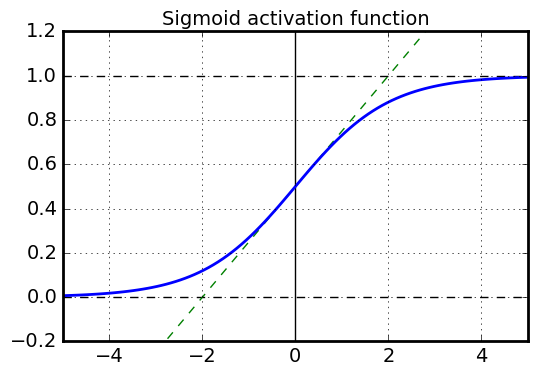

In [6]:
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(x, sigmoid(x), "b-", linewidth=2)
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2]);

## Xavier and He Initialization
Note: the book uses tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function. The main differences relevant to this chapter are:
several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.
the default activation is now None rather than tf.nn.relu.
it does not support tensorflow.contrib.framework.arg_scope() (introduced later in chapter 11).
it does not support regularizer params (introduced later in chapter 11).

In [7]:
reset_graph()

In [8]:
n_inputs = 28 * 28
num_unit_hidden_1 = 300
n_classes = 10

In [9]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')

#### weight initializer

In [10]:
he_init = tf.contrib.layers.variance_scaling_initializer()
hidden_1 = tf.layers.dense(X, n_inputs, kernel_initializer=he_init, activation=tf.nn.relu, name = 'hidden_1')

## Nonsaturating Activation Functions
##### Leaky ReLU

In [11]:
def leaky_relu(x, alpha = 0.01):
    return np.maximum(x, alpha * x)

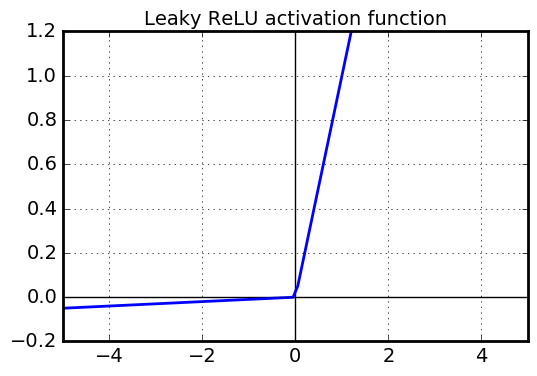

In [12]:
plt.plot([-5, 5], [0, 0], 'k-')
#plt.plot([-5, 5], [1, 1], 'k-')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot(x, leaky_relu(x), "b-", linewidth=2)
plt.grid(True)
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2]);

Implementing Leaky ReLU in TensorFlow:

In [13]:
reset_graph()

In [14]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')

In [15]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [16]:
def leaky_relu(z, alpha = 0.01, name=None):
    return tf.maximum(alpha * z, z, name=name)

In [17]:
hidden_1 = tf.layers.dense(X, num_unit_hidden_1, kernel_initializer = he_init, activation = leaky_relu , name = 'hidden_1')

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [18]:
reset_graph()

In [19]:
from tensorflow.examples.tutorials.mnist import input_data

In [20]:
mnist = input_data.read_data_sets('./data/')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [21]:
X_train = mnist.train.images
X_test  = mnist.test.images
y_train = mnist.train.labels.astype(np.int32)
y_test  = mnist.test.labels.astype(np.int32)

In [22]:
n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 100

In [23]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int32, shape = (None), name = 'y')

In [24]:
def leaky_relu(x, alpha = 0.01, name = None):
    return tf.maximum(alpha * x, x, name=name)

In [25]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [26]:
with tf.name_scope('fnn_leaky_relu'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, kernel_initializer = he_init, activation = leaky_relu, name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden_2, kernel_initializer = he_init, \
                               activation = leaky_relu, name = 'hidden_2')
    scores   = tf.layers.dense(hidden_2, n_classes, name = 'scores')

In [27]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(y, scores)
    loss = tf.reduce_mean(cross_entropy, name ='loss')
    loss_summary = tf.summary.scalar('loss_summary', loss)

In [28]:
learning_rate = 0.01

In [29]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [30]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(scores, y, 1)
    accuracy   = tf.reduce_mean(tf.cast(correct, tf.float32))

In [31]:
n_epochs = 40
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
checkpoint_path = './stored_models/fnn_leaky_relu_temp.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
finalmodel_path = './stored_models/fnn_leaky_relu_final'

In [34]:
import os

In [35]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
            
        saver.restore(sess, checkpoint_path)
        print('Training was interrupted and continue at epoch', start_epoch)
    else:
        start_epoch = 0
        sess.run(init)
        
    for epoch in range(start_epoch, n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
            
        if epoch % 5 == 0:
            accuracy_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
            accuracy_valid = accuracy.eval(feed_dict={X: mnist.validation.images, y:mnist.validation.labels})
            print('Epoch ', epoch, 'Training accuracy ', accuracy_train, 'Validation accuracy ', accuracy_valid)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b'%d' %(epoch+1))
    saver.save(sess, finalmodel_path)
    os.remove(checkpoint_epoch_path)

Epoch  0 Training accuracy  0.900036 Validation accuracy  0.9094
Epoch  5 Training accuracy  0.947927 Validation accuracy  0.9522
Epoch  10 Training accuracy  0.964836 Validation accuracy  0.9656
Epoch  15 Training accuracy  0.974655 Validation accuracy  0.9732
Epoch  20 Training accuracy  0.980582 Validation accuracy  0.976
Epoch  25 Training accuracy  0.985455 Validation accuracy  0.976
Epoch  30 Training accuracy  0.9886 Validation accuracy  0.9782
Epoch  35 Training accuracy  0.991345 Validation accuracy  0.9786


## ELU

In [36]:
def elu(x, alpha = 1, name = None):
    return np.where(x < 0, alpha * (np.exp(x)-1), x)

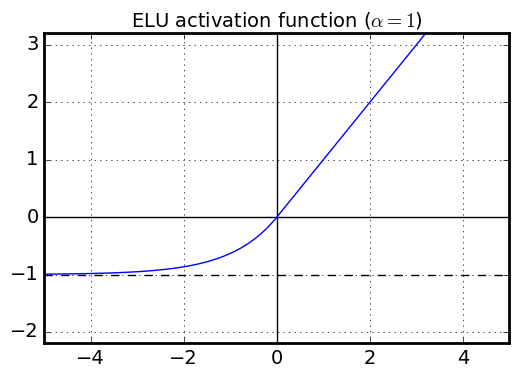

In [37]:
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.plot(x, elu(x))
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2]);

## breakthrough: Self-Normalizing Neural Networks (SELU) published at June 2017

This activation function was proposed by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [38]:
def selu(x, scale = 1.05, alpha = 1.67):
    elu_part = np.where(x < 0, alpha * (np.exp(x) - 1), x)
    scaled_elu = scale * elu_part
    return scaled_elu

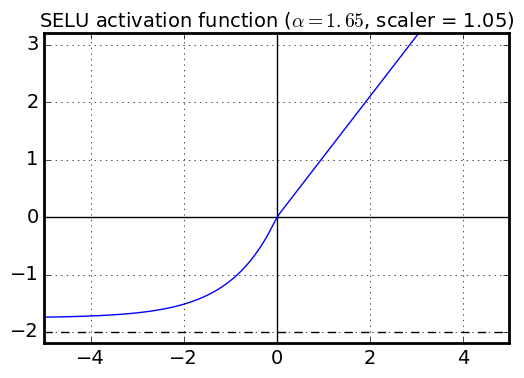

In [39]:
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-2, -2], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.plot(x, selu(x))
plt.grid(True)
plt.title(r"SELU activation function ($\alpha=1.65$, scaler = 1.05)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2]);

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [40]:
X = np.random.normal(size = (500, 100))

In [41]:
for layer in range(100):
    W = np.random.normal(size = (100, 100), scale=1/(np.sqrt(100)))
    Z = np.dot(X, W)
    scores = selu(Z)
    means = np.mean(scores, axis = 1)
    stds  = np.std(scores, axis = 1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.29, 0.79 < std deviation < 1.22
Layer 10: -0.27 < mean < 0.36, 0.77 < std deviation < 1.25
Layer 20: -0.33 < mean < 0.33, 0.77 < std deviation < 1.23
Layer 30: -0.23 < mean < 0.25, 0.79 < std deviation < 1.25
Layer 40: -0.32 < mean < 0.33, 0.76 < std deviation < 1.22
Layer 50: -0.22 < mean < 0.35, 0.75 < std deviation < 1.26
Layer 60: -0.29 < mean < 0.33, 0.74 < std deviation < 1.24
Layer 70: -0.31 < mean < 0.36, 0.76 < std deviation < 1.25
Layer 80: -0.32 < mean < 0.30, 0.74 < std deviation < 1.29
Layer 90: -0.26 < mean < 0.30, 0.75 < std deviation < 1.22


Here's a TensorFlow implementation:

In [42]:
def selu(x, alpha = 1.67, scale = 1.05):
    return scale * tf.where(x < 0, alpha * (tf.exp(x) - 1), x)

Let's create a neural net for MNIST using the SELU activation function:

In [43]:
reset_graph()

In [44]:
n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 100
learning_rate = 0.01

In [45]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

In [46]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [47]:
with tf.name_scope('fnn_selu'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, kernel_initializer = he_init, activation = selu, name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden_2, kernel_initializer = he_init, activation = selu, name = 'hidden_2')
    scores   = tf.layers.dense(hidden_2, n_classes, name = 'scores')

In [48]:
with tf.name_scope('loss'):
    #cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = scores)
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels= y, logits = scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')
    loss_summary = tf.summary.scalar('loss_summary', loss)

In [49]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [50]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(scores, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [51]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
checkpoint_path = './stored_models/fnn_selu_temp.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
finalmodel_path = './stored_models/fnn_selu_final'

In [53]:
n_epochs = 40
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

## Important: scaler to have a numerical stabilizer for std
Before we build the model, it is necessary to standardize and scale the inputs to mean 0 and standard deviation 1:

In [54]:
X_train = mnist.train.images
X_valid = mnist.validation.images

# 
X_train_means = np.mean(X_train, axis = 0, keepdims = True)

# numerical stabilizer
epsilon = 1e-10
X_train_stds  = np.std(X_train, axis = 0, keepdims = True) + epsilon

In [55]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        
        saver.restore(sess, checkpoint_path)
        print('Training was interrupted and will continue at epoch ', start_epoch)
    
    else:
        start_epoch = 0
        sess.run(init)
        print('Training gets started.....')
    
    for epoch in range(start_epoch, n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_standardized = (X_batch - X_train_means) / X_train_stds
            sess.run(train_obj, feed_dict={X: X_batch_standardized, y: y_batch})
        
        if epoch % 10 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_standardized, y: y_batch})
            
            X_valid_standardized = (X_valid - X_train_means) / X_train_stds            
            acc_valid = accuracy.eval(feed_dict={X: X_valid_standardized, y:mnist.validation.labels})
            print('  Epoch ', epoch, 'Training accuracy ', acc_train, 'Validation accuracy ', acc_valid)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b'%d' %(epoch + 1))
        
    save_path = saver.save(sess, finalmodel_path)
    os.remove(checkpoint_epoch_path)    

Training gets started.....
  Epoch  0 Training accuracy  0.92 Validation accuracy  0.9232
  Epoch  10 Training accuracy  0.94 Validation accuracy  0.9622
  Epoch  20 Training accuracy  1.0 Validation accuracy  0.9676
  Epoch  30 Training accuracy  1.0 Validation accuracy  0.9692


# Batch Normalization

At test time, there is no mini-batch to compute the empirical mean and standard deviation, so instead you
simply use the whole training set’s mean and standard deviation. These are typically efficiently computed
during training using a moving average. So, in total, four parameters are learned for each batchnormalized
layer: γ (scale), β (offset), μ (mean), and σ (standard deviation).

By using batch normalization, advantages are:
1. The vanishing gradients problem was strongly reduced.
2. The networks are also much less sensitive to the weight initialization. 
3. They were able to use much larger learning rates, significantly speeding up the learning process.
4. Batch Normalization also acts like a regularizer, reducing the need for other regularization techniques such as dropout.

Disadvantages:
1. Batch Normalization does, however, add some complexity to the model.
2. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. 

So if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization perform before playing with Batch Normalization.

In [56]:
def selu(x, alpha = 1.67, scale = 1.05):
    return scale * tf.where(x < 0, alpha * (tf.exp(x) - 1), x)

In [57]:
reset_graph()

n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 100

X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
training = tf.placeholder_with_default(False, shape = (), name = 'training')

hidden_1_before_bn = tf.layers.dense(X, num_unit_hidden_1, name = 'hidden_1_before_bn')
hidden_1_bn = tf.layers.batch_normalization(hidden_1_before_bn, training = training, momentum = 0.9)
hidden_1_after_bn  = selu(hidden_1_bn)

hidden_2_before_bn = tf.layers.dense(hidden_1_after_bn, num_unit_hidden_2, name = 'hidden_2_before_bn')
hidden_2_bn = tf.layers.batch_normalization(hidden_2_before_bn, training = training, momentum = 0.9)
hidden_2_after_bn = selu(hidden_2_bn)

scores_before_bn = tf.layers.dense(hidden_2_after_bn, n_classes, name = 'scores_before_bn')
scores_after_bn = tf.layers.batch_normalization(scores_before_bn, training = training, momentum = 0.9, name = 'scores')

To avoid repeating the same parameters over and over again, we can use Python's partial( ) function:

In [58]:
reset_graph()

In [59]:
from functools import partial

In [60]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')

In [61]:
training = tf.placeholder_with_default(False, shape = (), name = 'training')

In [62]:
my_batch_norm_layer = partial(tf.layers.batch_normalization, training = training, momentum = 0.9)

In [63]:
he_init = tf.contrib.layers.variance_scaling_initializer()

In [64]:
hidden_1_bf_bn = tf.layers.dense(X, num_unit_hidden_1, kernel_initializer = he_init, name = 'hidden_1_bf_bn')
hidden_1_bn = my_batch_norm_layer(hidden_1_bf_bn)
hidden_1_af_bn = selu(hidden_1_bn)

hidden_2_bf_bn = tf.layers.dense(hidden_1_af_bn, num_unit_hidden_2, kernel_initializer = he_init, name = 'hidden_2_bf_bn')
hidden_2_bn = my_batch_norm_layer(hidden_2_bf_bn)
hidden_2_af_bn = selu(hidden_2_bn)

scores_bf_bn = tf.layers.dense(hidden_2_af_bn, n_classes, name = 'scores_bf_bn')
scores_bn = my_batch_norm_layer(scores_bf_bn)
outputs = scores_bn

Let's build a neural net for MNIST, using the SELU activation function and Batch Normalization at each layer:

In [65]:
reset_graph()

In [66]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')
training = tf.placeholder_with_default(False, shape = (), name = 'training')

In [67]:
def self(x, alpha = 1.67, scale = 1.05):
    elu_part = tf.where(x < 0, alpha * (tf.exp(x) - 1), x)
    return scale * elu_part

In [68]:
batch_norm_momentum = 0.9

In [69]:
with tf.name_scope('dnn_bn_self'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    batch_norm_layer = partial(tf.layers.batch_normalization, training = training, momentum = batch_norm_momentum)
    dense_layer = partial(tf.layers.dense, kernel_initializer = he_init)
    
    hidden_1_bf_bn = dense_layer(X, num_unit_hidden_1, name = 'hidden_1_bf_bn')
    hidden_1_bn = batch_norm_layer(hidden_1_bf_bn, name = 'hidden_1_bn')
    hidden_1_af_bn = selu(hidden_1_bn)
    
    hidden_2_bf_bn = dense_layer(hidden_1_af_bn, num_unit_hidden_2, name = 'hidden_2_bf_bn')
    hidden_2_bn = batch_norm_layer(hidden_2_bf_bn, name = 'hidden_2_bn')
    hidden_2_af_bn = selu(hidden_2_bn)
    
    scores_bf_bn = dense_layer(hidden_2_af_bn, n_classes, name = 'scores_bf_bn')
    scores = batch_norm_layer(scores_bf_bn, name = 'scores')

In [70]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(y, scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [71]:
learning_rate = 0.01

In [72]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [73]:
with tf.name_scope('eval'):    
    correct = tf.nn.in_top_k(scores, y, 1)
    accuracy   = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [74]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [75]:
n_epochs = 30
batch_size = 200
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [76]:
checkpoint_path = './stored_models/dnn_bn_selu_temp.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
finalmodel_path = './stored_models/dnn_bn_selu_final.ckpt'

## Note to use batch_norm
Since we are using tf.layers.batch_normalization() , we need to explicitly run the extra update operations needed by batch normalization (sess.run([training_op, extra_update_ops],...).

In [77]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [78]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
        
        saver.restore(sess, checkpoint_path)
        print('Training was interrupt and will continue at epoch', start_epoch)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(start_epoch, n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            # because we are using batch_norm in dnn, so we need to manually update its shifter and scaler
            sess.run([train_obj, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        
        if epoch % 10 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
            acc_valid = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print('Epoch ', epoch, 'Training accuracy ', acc_train, 'Validation accuracy ', acc_valid)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b'%d' %(epoch+1))
    
    save_path = saver.save(sess, finalmodel_path)
    os.remove(checkpoint_epoch_path)

Epoch  0 Training accuracy  0.0992 Validation accuracy  0.8654
Epoch  10 Training accuracy  0.100091 Validation accuracy  0.9426
Epoch  20 Training accuracy  0.0999636 Validation accuracy  0.9612


In [79]:
[v.name for v in tf.trainable_variables()]

['hidden_1_bf_bn/kernel:0',
 'hidden_1_bf_bn/bias:0',
 'hidden_1_bn/beta:0',
 'hidden_1_bn/gamma:0',
 'hidden_2_bf_bn/kernel:0',
 'hidden_2_bf_bn/bias:0',
 'hidden_2_bn/beta:0',
 'hidden_2_bn/gamma:0',
 'scores_bf_bn/kernel:0',
 'scores_bf_bn/bias:0',
 'scores/beta:0',
 'scores/gamma:0']

In [80]:
[v.name for v in tf.global_variables()]

['hidden_1_bf_bn/kernel:0',
 'hidden_1_bf_bn/bias:0',
 'hidden_1_bn/beta:0',
 'hidden_1_bn/gamma:0',
 'hidden_1_bn/moving_mean:0',
 'hidden_1_bn/moving_variance:0',
 'hidden_2_bf_bn/kernel:0',
 'hidden_2_bf_bn/bias:0',
 'hidden_2_bn/beta:0',
 'hidden_2_bn/gamma:0',
 'hidden_2_bn/moving_mean:0',
 'hidden_2_bn/moving_variance:0',
 'scores_bf_bn/kernel:0',
 'scores_bf_bn/bias:0',
 'scores/beta:0',
 'scores/gamma:0',
 'scores/moving_mean:0',
 'scores/moving_variance:0']

## Gradient Clipping

In general people now prefer Batch
Normalization, but it’s still useful to know about Gradient Clipping and how to implement it.

In [81]:
reset_graph()

n_inputs = 28 * 28  # MNIST
num_unit_hidden1 = 300
num_unit_hidden2 = 50
num_unit_hidden3 = 50
num_unit_hidden4 = 50
num_unit_hidden5 = 50
n_classes = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [82]:
with tf.name_scope('dnn_grad_clip'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden1, activation = tf.nn.relu, name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden2, activation = tf.nn.relu, name = 'hidden_2')
    hidden_3 = tf.layers.dense(hidden_2, num_unit_hidden3, activation = tf.nn.relu, name = 'hidden_3')
    hidden_4 = tf.layers.dense(hidden_3, num_unit_hidden4, activation = tf.nn.relu, name = 'hidden_4')
    hidden_5 = tf.layers.dense(hidden_4, num_unit_hidden5, activation = tf.nn.relu, name = 'hidden_5')
    scores   = tf.layers.dense(hidden_5, n_classes, name = 'scores')

In [83]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(y, scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [84]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(scores, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:

In [85]:
threshold = 1
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_grad_vals = [(tf.clip_by_value(grad, -threshold, threshold), variance) for grad, variance in grads_and_vars]

In [86]:
train_obj = optimizer.apply_gradients(capped_grad_vals)

In [87]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [88]:
n_epochs = 20
batch_size = 200
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [89]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
        
        acc_valid = accuracy.eval(feed_dict={X: mnist.validation.images, y:mnist.validation.labels})
        print('Epoch ', epoch, 'Valid accuracy ', acc_valid)
    
    save_path = saver.save(sess, './stored_models/dnn_grad_clip.ckpt')

Epoch  0 Valid accuracy  0.294
Epoch  1 Valid accuracy  0.799
Epoch  2 Valid accuracy  0.8802
Epoch  3 Valid accuracy  0.9064
Epoch  4 Valid accuracy  0.9142
Epoch  5 Valid accuracy  0.9232
Epoch  6 Valid accuracy  0.9314
Epoch  7 Valid accuracy  0.9354
Epoch  8 Valid accuracy  0.9382
Epoch  9 Valid accuracy  0.9432
Epoch  10 Valid accuracy  0.9462
Epoch  11 Valid accuracy  0.9482
Epoch  12 Valid accuracy  0.9496
Epoch  13 Valid accuracy  0.952
Epoch  14 Valid accuracy  0.9546
Epoch  15 Valid accuracy  0.9572
Epoch  16 Valid accuracy  0.9584
Epoch  17 Valid accuracy  0.958
Epoch  18 Valid accuracy  0.96
Epoch  19 Valid accuracy  0.9602


# Reuse Pretrained Layers

## Reuse a TensorFlow Model Stored

First you need to load the graph's structure. The import_meta_graph() function does just that, loading the graph's operations into the default graph, and returning a Saver that you can then use to restore the model's state. Note that by default, a Saver saves the structure of the graph into a .meta file, so that's the file you should load:


In [90]:
reset_graph()

In [91]:
saver = tf.train.import_meta_graph("./stored_models/dnn_grad_clip.ckpt.meta")


Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [92]:
for operation in tf.get_default_graph().get_operations():
    print(operation.name)

X
y
hidden_1/kernel/Initializer/random_uniform/shape
hidden_1/kernel/Initializer/random_uniform/min
hidden_1/kernel/Initializer/random_uniform/max
hidden_1/kernel/Initializer/random_uniform/RandomUniform
hidden_1/kernel/Initializer/random_uniform/sub
hidden_1/kernel/Initializer/random_uniform/mul
hidden_1/kernel/Initializer/random_uniform
hidden_1/kernel
hidden_1/kernel/Assign
hidden_1/kernel/read
hidden_1/bias/Initializer/zeros
hidden_1/bias
hidden_1/bias/Assign
hidden_1/bias/read
dnn_grad_clip/hidden_1/MatMul
dnn_grad_clip/hidden_1/BiasAdd
dnn_grad_clip/hidden_1/Relu
hidden_2/kernel/Initializer/random_uniform/shape
hidden_2/kernel/Initializer/random_uniform/min
hidden_2/kernel/Initializer/random_uniform/max
hidden_2/kernel/Initializer/random_uniform/RandomUniform
hidden_2/kernel/Initializer/random_uniform/sub
hidden_2/kernel/Initializer/random_uniform/mul
hidden_2/kernel/Initializer/random_uniform
hidden_2/kernel
hidden_2/kernel/Assign
hidden_2/kernel/read
hidden_2/bias/Initializer/z

In [93]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [94]:
show_graph(tf.get_default_graph())


Once you know which operations you need, you can get a handle on them using the graph's get_operation_by_name() or get_tensor_by_name() methods:

In [95]:
X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')

In [96]:
accuracy = tf.get_default_graph().get_tensor_by_name('eval/accuracy:0')

In [97]:
train_obj = tf.get_default_graph().get_operation_by_name('GradientDescent')


If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [98]:
for operation in (X, y, accuracy, train_obj):
    tf.add_to_collection('my_important_operations', operation)


This way people who reuse your model will be able to simply write:

In [99]:
X, y, accuracy, train_obj = tf.get_collection('my_important_operations')


Now you can start a session, restore the model's state and continue training on your data:

In [100]:
with tf.Session() as sess:
    saver.restore(sess, './stored_models/dnn_grad_clip.ckpt')

    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = saver.save(sess, './stored_models/dnn_grad_clip_new_model.ckpt')

INFO:tensorflow:Restoring parameters from ./stored_models/dnn_grad_clip.ckpt
0 Test accuracy: 0.96
1 Test accuracy: 0.9617
2 Test accuracy: 0.9622
3 Test accuracy: 0.9626
4 Test accuracy: 0.9628
5 Test accuracy: 0.9638
6 Test accuracy: 0.9638
7 Test accuracy: 0.966
8 Test accuracy: 0.9665
9 Test accuracy: 0.9677
10 Test accuracy: 0.9636
11 Test accuracy: 0.9686
12 Test accuracy: 0.9663
13 Test accuracy: 0.9691
14 Test accuracy: 0.969
15 Test accuracy: 0.9681
16 Test accuracy: 0.9692
17 Test accuracy: 0.9694
18 Test accuracy: 0.9692
19 Test accuracy: 0.9688


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of import_meta_graph():


In general you will want to reuse only the lower layers. If you are using import_meta_graph() it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [101]:
reset_graph()

In [102]:
num_unit_hidden4 = 20  # new layer
num_unit_hidden5 = 20  # new layer
n_classes = 10  # new layer

In [103]:
# restore the graph
saver = tf.train.import_meta_graph('./stored_models/dnn_grad_clip.ckpt.meta')

In [104]:
# restore variables
X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')

In [105]:
# restore layers
hidden_3 = tf.get_default_graph().get_tensor_by_name('dnn_grad_clip/hidden_3/Relu:0')

In [106]:
# new layers
new_hidden_4 = tf.layers.dense(hidden_3, num_unit_hidden4, activation = tf.nn.relu, name = 'hidden_4')
new_hidden_5 = tf.layers.dense(new_hidden_4, num_unit_hidden5, activation = tf.nn.relu, name = 'hidden_5')
new_scores   = tf.layers.dense(new_hidden_5, n_classes, name = 'new_scores')

In [107]:
with tf.name_scope('new_loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = new_scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [108]:
with tf.name_scope('new_train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [109]:
with tf.name_scope('new_eval'):
    correct = tf.nn.in_top_k(predictions = new_scores, targets = y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [110]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [111]:
# restore the model stored and train new layers
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, './stored_models/dnn_grad_clip.ckpt')
    
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
        
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

    save_path = new_saver.save(sess, './stored_models/dnn_grad_clip_new_model.ckpt')

INFO:tensorflow:Restoring parameters from ./stored_models/dnn_grad_clip.ckpt
0 Test accuracy: 0.8129
1 Test accuracy: 0.9036
2 Test accuracy: 0.9295
3 Test accuracy: 0.9382
4 Test accuracy: 0.9445
5 Test accuracy: 0.9464
6 Test accuracy: 0.9518
7 Test accuracy: 0.952
8 Test accuracy: 0.9537
9 Test accuracy: 0.9598
10 Test accuracy: 0.9594
11 Test accuracy: 0.9496
12 Test accuracy: 0.9603
13 Test accuracy: 0.9618
14 Test accuracy: 0.963
15 Test accuracy: 0.9632
16 Test accuracy: 0.9645
17 Test accuracy: 0.9652
18 Test accuracy: 0.9633
19 Test accuracy: 0.9653


You must create one Saver to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another Saver to save the new model, once it is trained:

In [112]:
reset_graph()

In [113]:
saver = tf.train.import_meta_graph('./stored_models/dnn_grad_clip.ckpt.meta')

In [114]:
X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')
hidden_3 = tf.get_default_graph().get_tensor_by_name('dnn_grad_clip/hidden_3/Relu:0')

In [115]:
reuse_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'hidden_[123]') # regular expression
reuse_variables_dict = dict([(variable.op.name, variable) for variable in reuse_variables])

In [116]:
num_unit_hidden4 = 20  # new layer
num_unit_hidden5 = 20  # new layer
n_classes = 10  # new layer

# new layers
new_hidden_4 = tf.layers.dense(hidden_3, num_unit_hidden4, activation = tf.nn.relu, name = 'hidden_4')
new_hidden_5 = tf.layers.dense(new_hidden_4, num_unit_hidden5, activation = tf.nn.relu, name = 'hidden_5')
new_scores   = tf.layers.dense(new_hidden_5, n_classes, name = 'new_scores')

with tf.name_scope('new_loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = new_scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

with tf.name_scope('new_train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

with tf.name_scope('new_eval'):
    correct = tf.nn.in_top_k(predictions = new_scores, targets = y, k=1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')


In [117]:
restore_saver = tf.train.Saver(reuse_variables_dict) # to restore layers 1-3

In [118]:
reuse_variables_dict

{'hidden_1/bias': <tf.Variable 'hidden_1/bias:0' shape=(300,) dtype=float32_ref>,
 'hidden_1/kernel': <tf.Variable 'hidden_1/kernel:0' shape=(784, 300) dtype=float32_ref>,
 'hidden_2/bias': <tf.Variable 'hidden_2/bias:0' shape=(50,) dtype=float32_ref>,
 'hidden_2/kernel': <tf.Variable 'hidden_2/kernel:0' shape=(300, 50) dtype=float32_ref>,
 'hidden_3/bias': <tf.Variable 'hidden_3/bias:0' shape=(50,) dtype=float32_ref>,
 'hidden_3/kernel': <tf.Variable 'hidden_3/kernel:0' shape=(50, 50) dtype=float32_ref>}

In [119]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [120]:
with tf.Session() as sess:
    sess.run(init)
    restore_saver.restore(sess, './stored_models/dnn_grad_clip.ckpt')
    
    for epoch in range(n_epochs):                                      # not shown in the book
        for iteration in range(mnist.train.num_examples // batch_size): # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)      # not shown
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})  # not shown
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,  # not shown
                                                y: mnist.test.labels}) # not shown
        print(epoch, "Test accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, './stored_models/dnn_grad_clip_new_model.ckpt')

INFO:tensorflow:Restoring parameters from ./stored_models/dnn_grad_clip.ckpt
0 Test accuracy: 0.8283
1 Test accuracy: 0.9127
2 Test accuracy: 0.9283
3 Test accuracy: 0.9385
4 Test accuracy: 0.9463
5 Test accuracy: 0.9511
6 Test accuracy: 0.9544
7 Test accuracy: 0.9518
8 Test accuracy: 0.9571
9 Test accuracy: 0.9591
10 Test accuracy: 0.9602
11 Test accuracy: 0.9616
12 Test accuracy: 0.9612
13 Test accuracy: 0.962
14 Test accuracy: 0.9631
15 Test accuracy: 0.9637
16 Test accuracy: 0.9631
17 Test accuracy: 0.9643
18 Test accuracy: 0.9646
19 Test accuracy: 0.966


## Cache the frozen layers - original with batch_norm

In [121]:
reset_graph()

In [122]:
n_inputs = 28 * 28
n_classes = 10

In [123]:
num_unit_hidden_1 = 300
num_unit_hidden_2 = 100

In [124]:
num_unit_hidden_3 = 50

In [125]:
num_unit_hidden_4 = 50
num_unit_hidden_5 = 30

In [126]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

In [127]:
from functools import partial

bn_momentum = 0.9
training = tf.placeholder_with_default(False, shape = (), name = 'training')

In [128]:
def self(x, scale = 1.05, alpha = 1.65):
    return tf.where(x < 0, scale * (alpha * (tf.exp(x)-1)), x)

In [129]:
with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    bn_layer = partial(tf.layers.batch_normalization, training = training, momentum = bn_momentum)
    
    hidden_1_bf_bn = tf.layers.dense(X, num_unit_hidden_1, kernel_initializer = he_init, name = 'hidden_1')
    hidden_1_bn =bn_layer(hidden_1_bf_bn)
    hidden_1_af_bn = selu(hidden_1_bn)
    
    hidden_2_bf_bn = tf.layers.dense(hidden_1_af_bn, num_unit_hidden_2, kernel_initializer = he_init, name = 'hidden_2')
    hidden_2_bn = bn_layer(hidden_2_bf_bn)
    hidden_2_af_bn = selu(hidden_2_bn)
    
    
    hidden_3_bf_bn = tf.layers.dense(hidden_2_af_bn, num_unit_hidden_3, kernel_initializer = he_init, name = 'hidden_3')
    hidden_3_bn = bn_layer(hidden_3_bf_bn)
    hidden_3_af_bn = selu(hidden_3_bn)
    
    hidden_4_bf_bn = tf.layers.dense(hidden_3_af_bn, num_unit_hidden_4, kernel_initializer = he_init, name = 'hidden_4')
    hidden_4_bn = bn_layer(hidden_4_bf_bn)
    hidden_4_af_bn = selu(hidden_4_bn)
    
    hidden_5_bf_bn = tf.layers.dense(hidden_4_af_bn, num_unit_hidden_5, kernel_initializer = he_init, name = 'hidden_5')
    hidden_5_bn = bn_layer(hidden_5_bf_bn)
    hidden_5_af_bn = selu(hidden_5_bn)
    
    scores_bf_bn = tf.layers.dense(hidden_5_af_bn, n_classes, name = 'scores')
    scores = bn_layer(scores_bf_bn)    

In [130]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [131]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [132]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [133]:
n_epochs = 40
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [134]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [135]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [136]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([train_obj, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_valid = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print('Epoch ', epoch, 'Validation accuracy ', acc_valid)
    
    save_path = saver.save(sess, './stored_models/dnn_bn_selu_final.ckpt')

Epoch  0 Validation accuracy  0.9118
Epoch  10 Validation accuracy  0.9744
Epoch  20 Validation accuracy  0.9802
Epoch  30 Validation accuracy  0.9784


Frozen and cache layers 1 and 2

In [137]:
reset_graph()

In [138]:
n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 100
num_unit_hidden_3 = 50

In [139]:
new_num_unit_hidden_4 = 70
new_num_unit_hidden_5 = 50

In [140]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

In [141]:
training = tf.placeholder_with_default(False, shape = (), name = 'training')

In [142]:
bn_momentum = 0.9
bn_layer = partial(tf.layers.batch_normalization, training = training, momentum = bn_momentum)

In [143]:
with tf.name_scope('dnn'):
    he_init = tf.contrib.layers.variance_scaling_initializer()
    bn_layer = partial(tf.layers.batch_normalization, training = training, momentum = bn_momentum)
    
    hidden_1_bf_bn = tf.layers.dense(X, num_unit_hidden_1, kernel_initializer = he_init, name = 'hidden_1')
    hidden_1_bn =bn_layer(hidden_1_bf_bn)
    hidden_1_af_bn = selu(hidden_1_bn)
    
    hidden_2_bf_bn = tf.layers.dense(hidden_1_af_bn, num_unit_hidden_2, kernel_initializer = he_init, name = 'hidden_2')
    hidden_2_bn = bn_layer(hidden_2_bf_bn)
    hidden_2_af_bn = selu(hidden_2_bn)
    
    hidden_2_stop  = tf.stop_gradient(hidden_2_af_bn)
    
    hidden_3_bf_bn = tf.layers.dense(hidden_2_stop, num_unit_hidden_3, kernel_initializer = he_init, name = 'hidden_3')
    hidden_3_bn = bn_layer(hidden_3_bf_bn)
    hidden_3_af_bn = selu(hidden_3_bn)
    
    hidden_4_bf_bn = tf.layers.dense(hidden_3_af_bn, new_num_unit_hidden_4, kernel_initializer = he_init, name = 'hidden_4')
    hidden_4_bn = bn_layer(hidden_4_bf_bn)
    hidden_4_af_bn = selu(hidden_4_bn)
    
    hidden_5_bf_bn = tf.layers.dense(hidden_4_af_bn, new_num_unit_hidden_5, kernel_initializer = he_init, name = 'hidden_5')
    hidden_5_bn = bn_layer(hidden_5_bf_bn)
    hidden_5_af_bn = selu(hidden_5_bn)
    
    new_scores_bf_bn = tf.layers.dense(hidden_5_af_bn, n_classes, name = 'scores')
    new_scores = bn_layer(new_scores_bf_bn) 

In [144]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = new_scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [145]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = new_scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [146]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [147]:
n_epochs = 40
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [148]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

In [149]:
reuse_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'hidden_[123]')

In [150]:
reuse_variables_dict = dict([(var.op.name, var) for var in reuse_variables])

In [151]:
restore_saver = tf.train.Saver(reuse_variables_dict)

In [152]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [153]:
with tf.Session() as sess:
    sess.run(init)
    
    # change-1: restore_saver
    restore_saver.restore(sess, './stored_models/dnn_bn_selu_final.ckpt')
    
    # change-2: h2_cache to replace X_batch
    h2_cache = sess.run(hidden_2_bf_bn, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden_2_bf_bn, feed_dict={X: mnist.validation.images})
    
    for epoch in range(n_epochs):
        # change-3: shuffle_idx and hidden_2_batches -- replace n_batches and X_batch
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden_2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches  = np.array_split(y_train, n_batches)
        
        for hidden_2_batch, y_batch in zip(hidden_2_batches, y_batches):
            # change-4: hidden_2_bf_bn: hidden_2_batch to replace X: X_batch
            sess.run(train_obj, feed_dict={hidden_2_bf_bn: hidden_2_batch, y: y_batch})
        
        if epoch % 10 == 0:
            # change-5: hidden_2_bf_bn: h2_cache_valid to replace X: X_batch
            acc_valid = accuracy.eval(feed_dict={hidden_2_bf_bn: h2_cache_valid,
                                                y: mnist.validation.labels})
            print(epoch, "Test accuracy:", acc_valid) 
    
    save_path = new_saver.save(sess, './stored_models/dnn_bn_selu_final_new_layer_4_5.ckpt')

INFO:tensorflow:Restoring parameters from ./stored_models/dnn_bn_selu_final.ckpt
0 Test accuracy: 0.1126
10 Test accuracy: 0.0632
20 Test accuracy: 0.0674
30 Test accuracy: 0.1096


## Various optimizers

Five ways to speed up training (and reach a better solution): 
1. a good initialization strategy for the connection weights.
2. a good activation function.
3. a batch Normalization.
4. reuse parts of a pretrained network.
5. a faster optimizer than the regular Gradient Descent optimizer.

### Momentum optimization

To simulate some sort of friction mechanism and prevent the
momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, simply called the
momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is
0.9.

$
\begin{align}
&m = \beta \times m - \eta \times \nabla_{\theta}J(\theta)\\
&\theta = \theta - m \times \theta
\end{align}
$

The one drawback of Momentum optimization is that it adds yet another hyperparameter to tune. However,
the momentum value of 0.9 usually works well in practice and almost always goes faster than Gradient
Descent

In [154]:
momentum_optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9)

### Nesterov Accelerated Gradient

The idea of Nesterov Momentum optimization, or Nesterov
Accelerated Gradient (NAG), is to measure the gradient of the cost function not at the local position but
slightly ahead in the direction of the momentum. The only difference from vanilla
Momentum optimization is that the gradient is measured at $\theta + \beta m$ rather than at $\theta$.

$
\begin{align}
&m = \beta \times m - \eta \times \nabla_{\theta}J(\theta + \beta m)\\
&\theta = \theta - m \times \theta
\end{align}
$

This small tweak works because in general the momentum vector will be pointing in the right direction
(i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in
that direction rather than using the gradient at the original position.

NAG will almost always speed up training compared to regular Momentum optimization. To use it,
simply set use_nesterov=True when creating the MomentumOptimizer:

In [155]:
NAG_optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9, use_nesterov = True)

### AdaGrad

Gradient Descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley. It would be nice if the algorithm could detect this early on and correct its direction to point a bit more toward the global optimum.
The AdaGrad optimization achieves this by scaling down the gradient vector along the steepest dimensions.

$
\begin{align}
&s = s + (\nabla_{\theta}J(\theta))^{2}\\
&\theta = \theta - \eta \frac{( \nabla_{\theta}J(\theta))} {\sqrt{(s + \epsilon)}}
\end{align}
$

AdaGrad often performs well for simple quadratic problems, but unfortunately it often stops too early
when training neural networks. The learning rate gets scaled down so much that the algorithm ends up
stopping entirely before reaching the global optimum. So even though TensorFlow has an
AdagradOptimizer, you should not use it to train deep neural networks (it may be efficient for simpler
tasks such as Linear Regression, though).

In [156]:
AdaGrad_optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)

### RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the
RMSProp fixes this by accumulating only the gradients from the most recent iterations (as
opposed to all the gradients since the beginning of training). It does so by using exponential decay in the
first step. 

$
\begin{align}
&s = \beta s + (1 - \beta) \times (\nabla_{\theta}J(\theta))^{2}\\
&\theta = \theta - \eta \frac{( \nabla_{\theta}J(\theta))} {\sqrt{(s + \epsilon)}}
\end{align}
$

The decay rate $\beta$ is typically set to 0.9. Yes, it is once again a new hyperparameter, but this default value
often works well, so you may not need to tune it at all.

Except on very simple problems, this optimizer almost always performs much better than AdaGrad. It
also generally performs better than Momentum optimization and Nesterov Accelerated Gradients. In fact,
it was the preferred optimization algorithm of many researchers until Adam optimization came around.

In [157]:
RMSProp_optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate, momentum = 0.9, decay = 0.9, epsilon = 1e-10)

### Adam Optimization

Adam, which stands for adaptive moment estimation, combines the ideas of Momentum optimization
and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of
past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared
gradients.

$
\begin{align}
&m = \beta_{1} \times m + (1 - \beta_{1}) \times \nabla_{\theta}J(\theta)\\
&s = \beta_{2} \times s + (1 - \beta_{2}) \times (\nabla_{\theta}J(\theta))^{2}\\
&m = \frac{m}{1 - \beta_{1}}\\
&s = \frac{s}{1 - \beta_{2}}\\
&\theta = \theta - \eta \times \frac{m}{\sqrt{(s + \epsilon)}}
\end{align}
$

If you just look at steps 1, 2, and 5, you will notice Adam’s close similarity to both Momentum
optimization and RMSProp. The only difference is that step 1 computes an exponentially decaying
average rather than an exponentially decaying sum, but these are actually equivalent except for a constant
factor (the decaying average is just 1 – $\beta_{1}$ times the decaying sum). Steps 3 and 4 are somewhat of a
technical detail: since m and s are initialized at 0, they will be biased toward 0 at the beginning of
training, so these two steps will help boost m and s at the beginning of training.
The momentum decay hyperparameter $\beta_{1}$ is typically initialized to 0.9, while the scaling decay
hyperparameter $\beta_{2}$ is often initialized to 0.999. As earlier, the smoothing term $\epsilon$ is usually initialized to a
tiny number such as 10–8.

In [158]:
Adam_optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

In fact, since Adam is an adaptive learning rate algorithm (like AdaGrad and RMSProp), it requires less
tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta$ = 0.001, making Adam
even easier to use than Gradient Descent.

## Learning Rate Scheduling

you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate.

Four strategies:

1. Predetermined piecewise constant learning rate: For example, set the learning rate to $\eta_{0}$ = 0.1 at first, then to $\eta_{1}$ = 0.001 after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.

2. Performance scheduling: Measure the validation error every N steps (just like for early stopping) and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.

3. Exponential scheduling:Set the learning rate to a function of the iteration number t: $\eta(t) = \eta_{0}10^{–t/\gamma}$. This works great, but it requires tuning $\eta_{0}$ and $\gamma$. The learning rate will drop by a factor of 10 every r steps.

4. Power scheduling:Set the learning rate to $\eta(t) = \eta_{0} (1 + t/\gamma)^{–c}$. The hyperparameter $c$ is typically set to 1. This is similar to exponential scheduling, but the learning rate drops much more slowly.


In [159]:
reset_graph()
n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 50

X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int32, shape = (None), name = 'y')
#learning_rate = 0.001

with tf.name_scope('dnn'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, activation = tf.nn.relu, name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden_2, activation = tf.nn.relu, name = 'hidden_2')
    scores = tf.layers.dense(hidden_2, n_classes, name = 'scores')

with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

Here, we use the exponential scheduling strategy to find the optimal learning rate value
 $\eta(t) = \eta_{0}10^{–t/\gamma}$, where users need to specify $\eta_{0}$ and $\gamma$.

In [160]:
with tf.name_scope('train'):
    # \eta_{0}
    init_learning_rate = 0.1
    
    # gamma: 10000
    decay_steps = 10000
    
    decay_rate  = 1/10
    
    # global_step (initialized to 0) to keep track of the current training iteration number.
    global_step = tf.Variable(0.0, trainable = False, name = 'global_step')
    
    # specify learning rate for training: using exponential scheduling
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, decay_steps, decay_rate)
    
    # specify an optimization method
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9)
    
    # specify the loss function to optimize and addtional global steps to find the optimal learning rate
    train_obj = optimizer.minimize(loss, global_step = global_step)

In [161]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [162]:
n_epochs = 5
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [163]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict = {X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict = {X: mnist.validation.images, y: mnist.validation.labels})
        print('Epoch ', epoch, 'Validation accuracy ', acc_valid)
    
    save_path = saver.save(sess, './stored_models/dnn_momentum_optimizer_learning_scheduling.ckpt')

Epoch  0 Validation accuracy  0.9676
Epoch  1 Validation accuracy  0.9782
Epoch  2 Validation accuracy  0.977
Epoch  3 Validation accuracy  0.9802
Epoch  4 Validation accuracy  0.9796


Since AdaGrad, RMSProp, and Adam optimization automatically reduce the learning rate during training,
it is not necessary to add an extra learning schedule. For other optimization algorithms, using exponential
decay or performance scheduling can considerably speed up convergence.

# Avoiding Overfitting Through Regularization

## $\ell_{1}$ and $\ell_{2}$ regularization

Implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [164]:
reset_graph()
n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300

X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

with tf.name_scope('dnn'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, name = 'hidden_1')
    scores = tf.layers.dense(hidden_1, n_classes, name = 'scores')

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [165]:
W1 = tf.get_default_graph().get_tensor_by_name('hidden_1/kernel:0')
W2 = tf.get_default_graph().get_tensor_by_name('scores/kernel:0')

In [166]:
scale = 0.001

In [167]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = scores)
    base_loss = tf.reduce_mean(cross_entropy, name = 'avg_cross_entropy')
    
    # L1 regularization: absolute value of weights
    reg_loss = tf.reduce_mean(tf.abs(W1)) + tf.reduce_mean(tf.abs(W2))
    
    loss = tf.add(base_loss, scale * reg_loss, name = 'loss')

In [168]:
learning_rate = 0.01

In [169]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [170]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [171]:
init = tf.global_variables_initializer()

In [172]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                                y: mnist.test.labels})
        print(epoch, "Test accuracy:", accuracy_val)

0 Test accuracy: 0.892
1 Test accuracy: 0.9
2 Test accuracy: 0.9084
3 Test accuracy: 0.9068
4 Test accuracy: 0.9081
5 Test accuracy: 0.9111
6 Test accuracy: 0.9045
7 Test accuracy: 0.9072
8 Test accuracy: 0.8957
9 Test accuracy: 0.9139
10 Test accuracy: 0.9055
11 Test accuracy: 0.9083
12 Test accuracy: 0.9084
13 Test accuracy: 0.9046
14 Test accuracy: 0.911
15 Test accuracy: 0.906
16 Test accuracy: 0.9118
17 Test accuracy: 0.9026
18 Test accuracy: 0.9094
19 Test accuracy: 0.9156


Alternatively, we can pass a regularization function to the tf.layers.dense() function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [173]:
reset_graph()

n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 50

X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name ='y')

In [174]:
scale = 0.01
with tf.name_scope('dnn'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, \
                               kernel_regularizer = tf.contrib.layers.l1_regularizer(scale), name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden_2, \
                               kernel_regularizer = tf.contrib.layers.l1_regularizer(scale), name = 'hidden_2')
    scores   = tf.layers.dense(hidden_2, n_classes, name = 'scores')

In [175]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = scores)
    base_loss = tf.reduce_mean(cross_entropy, name = 'avg_cross_entropy')
    
    # we need to retrieve the regularization terms from get_collection function
    reg_loss  = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    
    loss = tf.add_n([base_loss] + reg_loss, name = 'loss')

In [176]:
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    train_obj = optimizer.minimize(loss)

In [177]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [178]:
init = tf.global_variables_initializer()

In [179]:
n_epochs = 20
batch_size = 200
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: mnist.validation.images,
                                                y: mnist.validation.labels})
        print(epoch, "Validation accuracy:", acc_valid)

0 Validation accuracy: 0.852
1 Validation accuracy: 0.8694
2 Validation accuracy: 0.8774
3 Validation accuracy: 0.8614
4 Validation accuracy: 0.8676
5 Validation accuracy: 0.858
6 Validation accuracy: 0.8654
7 Validation accuracy: 0.8838
8 Validation accuracy: 0.8754
9 Validation accuracy: 0.867
10 Validation accuracy: 0.8756
11 Validation accuracy: 0.8702
12 Validation accuracy: 0.86
13 Validation accuracy: 0.8634
14 Validation accuracy: 0.864
15 Validation accuracy: 0.8548
16 Validation accuracy: 0.8804
17 Validation accuracy: 0.8766
18 Validation accuracy: 0.8622
19 Validation accuracy: 0.8742


# Dropout

The tf.layers.dropout() function is almost identical to the tf.contrib.layers.dropout() function, except for a few minor differences. Most importantly:

1. you must specify the dropout rate (rate) rather than the keep probability (keep_prob).
2. the is_training parameter is renamed to training.


sess.run(train_obj, feed_dict={training: True, X: X_batch, y: y_batch})

In [180]:
reset_graph()

In [181]:
n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 50

In [182]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

In [183]:
training = tf.placeholder_with_default(False, shape = (), name = 'training')

In [184]:
dropout_rate = 0.5

In [185]:
X_dropout = tf.layers.dropout(X, rate = dropout_rate, training = training, name = 'dropout')

In [186]:
with tf.name_scope('dnn'):
    hidden_1 = tf.layers.dense(X_dropout, num_unit_hidden_1, activation = tf.nn.relu, name = 'hidden_1')
    hidden_1_dropout = tf.layers.dropout(hidden_1, rate = dropout_rate, training = training)
    
    hidden_2 = tf.layers.dense(hidden_1_dropout, num_unit_hidden_2, activation = tf.nn.relu, name = 'hidden_2')
    hidden_2_dropout = tf.layers.dropout(hidden_2, rate = dropout_rate, training = training)
    
    scores = tf.layers.dense(hidden_2_dropout, n_classes, name = 'scores')

In [187]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
    loss = tf.reduce_mean(cross_entropy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    train_obj = optimizer.minimize(loss)    

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [188]:
n_epochs = 20
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            # !!!! need to set training to True, when we are doing training
            sess.run(train_obj, feed_dict={training: True, X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
        print(epoch, 'Validation accuracy:', acc_valid)

0 Validation accuracy: 0.9254
1 Validation accuracy: 0.9432
2 Validation accuracy: 0.955
3 Validation accuracy: 0.957
4 Validation accuracy: 0.9596
5 Validation accuracy: 0.9636
6 Validation accuracy: 0.962
7 Validation accuracy: 0.9674
8 Validation accuracy: 0.9672
9 Validation accuracy: 0.9682
10 Validation accuracy: 0.966
11 Validation accuracy: 0.9678
12 Validation accuracy: 0.9698
13 Validation accuracy: 0.9708
14 Validation accuracy: 0.9732
15 Validation accuracy: 0.9702
16 Validation accuracy: 0.9724
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9742
19 Validation accuracy: 0.9728


# Max-norm regularization

Another regularization technique that is quite popular for neural networks is called max-norm
regularization: for each neuron, it constrains the weights w of the incoming connections such that $||W||_{2}≤ r$, where $r$ is the max-norm hyperparameter and $||\cdot||_{2}$ is the $\ell_{2}$ norm.
We typically implement this constraint by computing $||W||_{2}$ after each training step and clipping $W$ if
needed: 

$\begin{align}
W = W \times \frac{r}{||W||_{2}}
\end{align}
$

Reducing $r$ increases the amount of regularization and helps reduce overfitting. Max-norm regularization
can also help alleviate the vanishing/exploding gradients problems (if you are not using Batch
Normalization).

In [189]:
reset_graph()

n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 50

In [190]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

In [191]:
learning_rate = 0.01
momentum = 0.9

In [192]:
with tf.name_scope('dnn'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, activation = tf.nn.relu, name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden_2, activation = tf.nn.relu, name = 'hidden_2')
    scores   = tf.layers.dense(hidden_2, n_classes, name = 'scores')

In [193]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [194]:
with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = momentum)
    train_obj = optimizer.minimize(loss)

In [195]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

Max-norm clip

In [196]:
norm_threshold = 1.0

weights for the first layers

In [197]:
weights_1 = tf.get_default_graph().get_tensor_by_name('hidden_1/kernel:0')
clip_weights = tf.clip_by_norm(clip_norm = norm_threshold, t = weights_1, axes = 1)
clipped_ops = tf.assign(weights_1, clip_weights)

weights for the second layers

In [198]:
weights_2 = tf.get_default_graph().get_tensor_by_name('hidden_2/kernel:0')
clip_weights_2 = tf.clip_by_norm(clip_norm = norm_threshold, t = weights_2, axes = 1)
clipped_ops_2  = tf.assign(weights_2, clip_weights_2)

general procedure to create session and train dnn, but we need to execute the clipped_ops using mini batch.

In [199]:
n_epochs = 20
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [200]:
init = tf.global_variables_initializer()

In [201]:
with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict = {X: X_batch, y: y_batch})
            clipped_ops.eval()
            clipped_ops_2.eval()
        if epoch % 5 == 0:
            acc_valid = accuracy.eval(feed_dict = {X: mnist.validation.images, y: mnist.validation.labels})
            print('Epoch ', epoch, 'Valid accuracy ', acc_valid)

Epoch  0 Valid accuracy  0.9562
Epoch  5 Valid accuracy  0.9806
Epoch  10 Valid accuracy  0.9816
Epoch  15 Valid accuracy  0.9848


### Create a Max_norm function rather than naive implementation


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a max_norm_regularizer() function:

In [202]:
def max_norm_regularizer(threshold, axes = 1, name = 'max_norm', collection = 'max_norm'):
    def max_norm(weights):
        clipped = tf.clip_by_norm(clip_norm = threshold, t = weights, axes = axes)
        clipped_ops = tf.assign(weights, clipped, name = name)
        tf.add_to_collection(collection, clipped_ops)
        return None
    return max_norm

In [203]:
reset_graph()

n_inputs = 28 * 28
n_classes = 10
num_unit_hidden_1 = 300
num_unit_hidden_2 = 50

X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

learning_rate = 0.01
momentum = 0.9

In [204]:
with tf.name_scope('dnn'):
    hidden_1 = tf.layers.dense(X, num_unit_hidden_1, activation = tf.nn.relu, \
                               kernel_regularizer = max_norm_regularizer(threshold = norm_threshold), name = 'hidden_1')
    hidden_2 = tf.layers.dense(hidden_1, num_unit_hidden_2, activation = tf.nn.relu, \
                               kernel_regularizer = max_norm_regularizer(threshold = norm_threshold), name = 'hidden_2')
    scores   = tf.layers.dense(hidden_2, n_classes, name = 'scores')

In [205]:
with tf.name_scope('loss'):
    cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = scores)
    loss = tf.reduce_mean(cross_entropy, name = 'loss')

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = momentum)
    train_obj = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [206]:
init = tf.global_variables_initializer()

In [207]:
n_epochs = 20
batch_size = 50
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

Important: because we use the function to update all weight max norm clipping, so we need to specify all necessary operations by using get_collection()

In [208]:
clip_all_weights = tf.get_collection('max_norm')

In [209]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(train_obj, feed_dict = {X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        if epoch % 5 == 0:
            acc_valid = accuracy.eval(feed_dict = {X: mnist.validation.images, y: mnist.validation.labels})
            print('Epoch', epoch, '\tValid accuracy', acc_valid)

Epoch 0 	Valid accuracy 0.9564
Epoch 5 	Valid accuracy 0.98
Epoch 10 	Valid accuracy 0.9838
Epoch 15 	Valid accuracy 0.9844


# Exercise.1 -- Deep Learning

### Problem.1
Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function.
We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [210]:
reset_graph()

In [211]:
def dnn(inputs, n_layers, num_unit, kernel_init, activationFcn, name = None):
    with tf.variable_scope(name, 'dnn'):
        for layer in range(n_layers):
            layers = tf.layers.dense(inputs, num_unit, kernel_initializer = kernel_init, activation = activationFcn,\
                                     name = 'hidden_%d' % (layer+1) )
        return layers

In [212]:
he_init = tf.contrib.layers.variance_scaling_initializer()
eluFcn = tf.nn.elu

Using Adam optimization and early stopping, try training it on MNIST but only on digits 0
to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a
softmax output layer with five neurons, and as always make sure to save checkpoints at
regular intervals and save the final model so you can reuse it later.

In [213]:
n_inputs = 28 * 28
n_classes = 5

In [214]:
X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')

Create the sandwish layers excluding the score layer.

In [215]:
dnn_outputs = dnn(X, n_layers = 5, num_unit = 100, kernel_init = he_init, activationFcn = eluFcn)

Create the score layer to calculate the 'logits'.

In [216]:
scores = tf.layers.dense(dnn_outputs, n_classes, name = 'scores')

Create a layer to yield predictions.

In [217]:
y_proba = tf.nn.softmax(scores, name = 'y_proba')

### Problem.2 

Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later.

Let's start from completing the graph with the cost function, the training op, and all the other usual components:

In [218]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = scores)
loss = tf.reduce_mean(cross_entropy, name = 'loss')

In [219]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_obj = optimizer.minimize(loss, name = 'train_obj')

In [220]:
correct = tf.nn.in_top_k(predictions = scores, targets = y, k = 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')

In [221]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Fetch the MNIST dataset

In [222]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/')

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [223]:
X_train = mnist.train.images[mnist.train.labels < 5]
y_train = mnist.train.labels[mnist.train.labels < 5]
X_valid = mnist.validation.images[mnist.validation.labels < 5]
y_valid = mnist.validation.labels[mnist.validation.labels < 5]
X_test  = mnist.test.images[mnist.test.labels < 5]
y_test  = mnist.test.labels[mnist.test.labels < 5]

In [224]:
n_epochs = 1000
batch_size = 20
n_batches = int(np.ceil(mnist.train.num_examples / batch_size))

In [225]:
max_checks_without_progress = 20
checks_without_progress = 0

In [226]:
best_valid_loss = np.infty

In [227]:
checkpoint_path = './stored_models/dnn_exercise_8_tmp.ckpt'
checkpoint_epoch_path = checkpoint_path + '.epoch'
finalmodel_path = './stored_models/dnn_exercise_8_final.ckpt'

In [228]:
import os

In [229]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path):
        with open(checkpoint_epoch_path, 'rb') as f:
            start_epoch = int(f.read())
            print('Training is interrupted and will continue at Epoch ', start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(n_epochs):
        # because we only use digits 0-4, so we can't use the built-in function to retrieve mini batch
        shuffled_idx = np.random.permutation(len(X_train))
        
        X_batches = np.array_split(X_train[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        
        # train dnn by optimizing train_obj function
        for X_batch, y_batch in zip(X_batches, y_batches):
            sess.run(train_obj, feed_dict={X: X_batch, y: y_batch})
        
        # evaluate loss and accuracy 
        loss_valid, acc_valid = sess.run([loss, accuracy], feed_dict = {X: X_valid, y: y_valid})
        
        # compare the existing best model validation loss, 
        # if the current model has lower validation loss, then we use the current model as the best model
        if loss_valid < best_valid_loss:
            best_valid_loss = loss_valid
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, 'wb') as f:
                f.write(b'%d'%(epoch+1))
            # reset the checks_without_progress
            checks_without_progress = 0
        else:
            checks_without_progress += 2
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping')
                break
        
        # print-out the training status
        print('Epoch: {}\tCurrent Loss:{:.6f}\tBest Loss:{:.6f}\tValid Accuracy:{:.2f}%'\
              .format(epoch, loss_valid, best_valid_loss, acc_valid*100))
        
    save_path = saver.save(sess, finalmodel_path)
    os.remove(checkpoint_epoch_path)

Epoch: 0	Current Loss:0.107613	Best Loss:0.107613	Valid Accuracy:97.93%
Epoch: 1	Current Loss:0.123725	Best Loss:0.107613	Valid Accuracy:97.54%
Epoch: 2	Current Loss:0.316240	Best Loss:0.107613	Valid Accuracy:96.91%
Epoch: 3	Current Loss:0.166849	Best Loss:0.107613	Valid Accuracy:98.12%
Epoch: 4	Current Loss:0.179020	Best Loss:0.107613	Valid Accuracy:98.24%
Epoch: 5	Current Loss:0.220427	Best Loss:0.107613	Valid Accuracy:97.81%
Epoch: 6	Current Loss:0.170060	Best Loss:0.107613	Valid Accuracy:98.28%
Epoch: 7	Current Loss:0.266168	Best Loss:0.107613	Valid Accuracy:97.73%
Epoch: 8	Current Loss:0.233071	Best Loss:0.107613	Valid Accuracy:98.55%
Epoch: 9	Current Loss:0.193980	Best Loss:0.107613	Valid Accuracy:98.87%
Epoch: 10	Current Loss:0.155122	Best Loss:0.107613	Valid Accuracy:98.83%
Early stopping


Test the performance of best model on test dataset.

In [230]:
with tf.Session() as sess:
    saver.restore(sess, finalmodel_path)
    acc_test = accuracy.eval(feed_dict = {X: X_test, y: y_test})

INFO:tensorflow:Restoring parameters from ./stored_models/dnn_exercise_8_final.ckpt


In [231]:
print('The accuracy of best model on test set is {:.2f}%'.format(acc_test * 100))

The accuracy of best model on test set is 98.99%


### Problem.3

Tune the hyperparameters using cross-validation and see what precision you can achieve.

Create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much like the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [232]:
from sklearn.base import BaseEstimator, ClassifierMixin

Here, if we do not use the ClassifierMixin to create the DNNClass, then it will have error when we tune hyperparameters using 
RandomizedSearchCV without specifying a concrete score function in DNNClass.

In [233]:
from sklearn.exceptions import NotFittedError

In [427]:
class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers = 5, num_units_each_layer = [100, 100, 70, 50, 30], \
                 kernel_init = tf.contrib.layers.variance_scaling_initializer(), activationFcn = tf.nn.relu,\
                 optimizer = tf.train.AdamOptimizer,\
                 learning_rate = 0.01, n_epochs = 100, batch_size = 20,\
                 batch_norm_momentum = 0.9, dropout_rate = 0.5,\
                 batch_norm_use = None, dropout_use = None, random_state=None):
        
        self.n_hidden_layers = n_hidden_layers
        self.num_units_each_layer = num_units_each_layer
        self.kernel_init = kernel_init
        self.activationFcn = activationFcn
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.batch_norm_use = batch_norm_use
        self.dropout_use = dropout_use
        self.random_state = random_state
        
        # to globally set a tf session
        self._session = None
    
    ## 1. a uncalled function (i.e. only eligible to be called within other sub-functions) to create hidden layers.
    ##
    ## -- Input: Input from training data; information of hidden layers can be retrieved from self container
    ## -- Output: hidden layers
    def _dnn(self, inputs):
        for layer in range(self.n_hidden_layers):
            
            # the order of constructing a dnn is: -- dropout (if capable) -- matmul -- batch norm (if capable) -- activation
            
            # 1.1 dropout (if capable)
            if self.dropout_use:
                inputs = tf.layers.dropout(inputs, rate = self.dropout_rate, training = self._training)
            
            # 1.2 matrix multiplication
            inputs = tf.layers.dense(inputs, num_units_each_layer[layer], kernel_initializer = self.kernel_init,\
                                     name = 'hidden_%d' %(layer + 1))
            
            # 1.3 bath normalization (if capable)
            if self.batch_norm_use:
                inputs = tf.layers.batch_normalization(inputs, momentum = self.batch_norm_momentum, training = self._training)
            
            # 1.4 activation stored in the self container
            inputs = self.activationFcn(inputs, name = 'hidden_%d_output' %(layer + 1))
        
        return inputs
    
    ## 2. a uncalled function to construct a computing graph, which is the typical construct for a dnn network
    ##
    ## -- set random_seed
    ## -- initialize X and y
    ## -- set training status for batch_norm or dropout (if capable)
    ## -- create layers from input to the last second hidden layer
    ## -- calculate logits (the last layer a.k.a fully connected layer) and scores -- softmax
    ## -- specify loss, optimizer, train_obj function and accuracy
    ## -- specify init and saver
    def _build_graph(self, n_inputs, n_classes):
        # 2.1 if we have random_seed
        if self.random_state:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)
        
        # 2.2 initialize X and y to store training data
        X = tf.placeholder(dtype = tf.float32, shape = (None, n_inputs), name ='X')
        y = tf.placeholder(dtype = tf.int64, shape = (None), name = 'y')
        
        # 2.3 set training status for batch norm or dropout
        if self.batch_norm_use is not None or self.dropout_use is not None:
            self._training = tf.placeholder_with_default(False, shape = (), name = 'training')
        else:
            self._training = None
            
        # 2.4 create layers from input to the last second hidden layer
        dnn_hidden_layers = self._dnn(X)
        
        # 2.5 calculate logits (the fully connected layer) and y_proba
        logits = tf.layers.dense(dnn_hidden_layers, self.n_classes_, kernel_initializer = self.kernel_init, name = 'logits')
        scores = tf.nn.softmax(logits, name = 'scores')
        
        # 2.6 specify cross entropy (from logits) and loss
        cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels = y, logits = logits)
        loss = tf.reduce_mean(cross_entropy, name = 'loss')
        
        # 2.7 specify optimizer and train_obj
        optimizer = self.optimizer(learning_rate = self.learning_rate)
        train_obj = optimizer.minimize(loss)
        
        # 2.8 specify accuracy
        correct = tf.nn.in_top_k(predictions = logits, targets = y, k = 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name = 'accuracy')
        
        # 2.9 specify init and saver
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        
        # 2.10 store in self container: make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._scores, self._loss = scores, loss
        self._train_obj = train_obj
        self._accuracy = accuracy
        self._init, self._saver = init, saver
    
    ## 3. create a callable function to close session
    def close_session(self):
        if self._session:
            self._session.close()
    
    ## 4. create a uncalled function to retrieve all global varialbes of model built
    def _get_model_params(self):
        # Get all variable values (used for early stopping, faster than saving to disk)
        with self._graph.as_default():
            global_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        
        ### !!!!!!!!!!!!!!!!!! simultaneously perform session to get parameters and their information
        global_params_dict = {param.op.name: value for param, value in zip(global_params, self._session.run(global_params))}
        
        return global_params_dict
    
    
    ## 5. create a uncalled function to restore/reload all global variables model built
    ## -- Input: model_params is the global_params_dict obtained from executing _get_model_params() function
    def _restore_model_params(self, model_params):
        # Set all variables to the given values (for early stopping, faster than loading from disk)
        
        # 5.1 get names of model parameters and store as a list
        model_params_names = list(model_params.keys())
        
        # 5.2 specify the assign operation dictory for assign/update value of each model parameter.
        assign_ops = {model_param_name: self._graph.get_operation_by_name(model_param_name + '/Assign') \
                      for model_param_name in model_params_names}
        
        # 5.3 specify the initial value to assign the parameters
        init_values = {model_param_name: assign_op.inputs[1] for model_param_name, assign_op in assign_ops.items()}
        
        # 5.4 specify feed_dict for each operation to assign value for model parameters
        feed_dict = {init_values[model_param_name]:model_params[model_param_name] for model_param_name in model_params_names}
        
        # 5.5 execute the operations to assign values
        self._session.run(assign_ops, feed_dict)
    
    ## 6. a callable function to build the dnn network
    ## -- fit the model to the training set. If X_valid and y_valid are provided, use early stopping.
    def fit(self, X, y, X_valid = None, y_valid = None):
        
        # 6.1 close the session if there is one existed
        self.close_session()
        
        # 6.2 initialize the general algorithmic settings
        
        n_epochs = self.n_epochs
        batch_size = self.batch_size
        n_batches = int(np.ceil(len(X) / batch_size))
        
        n_inputs = X.shape[1]
        n_classes = len(np.unique(y))
        self.n_classes_ = n_classes
        self.classes_ = np.unique(y)
        
        # 6.3 translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        class_to_index = {label: index for index, label in enumerate(self.classes_)}
        self.class_to_index_ = class_to_index
        y = np.array([self.class_to_index_[label] for label in y], dtype = np.int32)
        
        # 6.4 create a graph to execute all operations
        self._graph = tf.Graph()
        
        # 6.5 construct the dnn network with setting the current graph as default
        #     also record all extra update operations if we use batch normalization
        with self._graph.as_default():
            self._build_graph(n_inputs, n_classes)
            #if self.batch_norm_use:
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        # 6.6 specify settings for early stopping
        check_without_progress = 0
        max_checks_without_progress = 20
        best_valid_loss = np.infty
        best_params = None
        
        # 6.7 we need to activate session in self container with specifying the graph to the one in self-container
        self._session = tf.Session(graph = self._graph)
        
        # 6.8 train the model: we set the session in self container as the default session
        with self._session.as_default() as sess:
            sess.run(self._init)
            
            # 6.8.1 loop over all n_epochs
            for epoch in range(self.n_epochs):
                # 6.8.1.1 shuffle indice of training set
                shuffled_idx = np.random.permutation(len(X))
                
                # 6.8.1.2 split the training set to yield mini batches
                for idx in np.array_split(shuffled_idx, len(X) / self.batch_size):
                    X_batch, y_batch = X[idx], y[idx]
                    
                    # 6.8.1.2.1 specify feed_dict's _X and _y in self container to X_batch and y_batch
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    
                    # 6.8.1.2.2 determine whether the batch_norm is in the training mode, 
                    #           if so set the training in feed_dict to true
                    if self._training is not None:
                        feed_dict[self._training] = True
                    
                    # 6.8.1.2.3 evaluate the train_obj to optimize the loss
                    sess.run(self._train_obj, feed_dict = feed_dict)
                    
                    # 6.8.1.2.4 if extra_update_ops is not None, i.e. we use batch_normalization
                    if extra_update_ops is not None:
                        sess.run(extra_update_ops, feed_dict = feed_dict)
                    
                # 6.8.1.3 after the current epoch looping over all mini-batches to optimize train object function
                #         if the validation set is provided, then we evaluate the loss and accuracy
                #         also, it means that we use early stopping
                if X_valid is not None and y_valid is not None:
                    loss_valid, acc_valid = sess.run([self._loss, self._accuracy], \
                                                     feed_dict = {self._X: X_valid, self._y: y_valid})

                    # check the progress and determine whether we should trigger early stopping
                    if loss_valid < best_valid_loss:
                        best_params = self._get_model_params()
                        best_valid_loss = loss_valid
                        check_without_progress = 0
                    else:
                        check_without_progress += 1
                    # print-out the training status
                    print('{} epoch\tValidation Loss: {:.6f}\tBest Loss: {:.6f}\tValidation Accuracy: {:.2f}%'\
                          .format(epoch, loss_valid, best_valid_loss, acc_valid))

                    if check_without_progress > max_checks_without_progress:
                        print('Early Stopping!')
                        break

                # 6.8.1.4 if there is no validation set, we will evaluate training loss and accuracy
                else:
                    loss_train, accuracy_train = sess.run([self._loss, self._accuracy],\
                                                          feed_dict = {self._X: X_batch, self._y: y_batch})
                    print('{} epoch\tTraining Loss: {:.6f}\tTraining Accuracy: {:.2f}%'\
                          .format(epoch, loss_train, acc_train))
                    
                    
            # 6.8.2 If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            
            # 6.8.3 return the self container
            return self
    
    ## 7. a callable function to produce probability predictions using self._scores
    def predict_proba(self, X):
        # exception if there is no session to execute
        if not self._session:
            raise NotFittedError('This %s instance is not fitted yet' % (self.__class__.__name__))
        
        # otherwise, activate the session to execute self._scores function to get probabilistic predictions
        with self._session.as_default() as sess:
            prediction_probability = self._scores.eval(feed_dict = {self._X: X})
        
        return prediction_probability
    
    # 8. a callable function to produce a concrete class prediction based on probabilities predicted
    def predict(self, X):
        prediction_probability = self.predict_proba(X)
        class_indice = np.argmax(prediction_probability, axis = 1)
        predict_class = np.array([self.class_to_index_[class_index] for class_index in class_indice], dtype = np.int32)
        return predict_class
    
    # 9. a callable function to store the current model
    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [428]:
dnn_clf = DNNClassifier(random_state=42)

In [429]:
dnn_clf.fit(X_train, y_train, X_valid=X_valid, y_valid=y_valid)

0 epoch	Validation Loss: 0.081314	Best Loss: 0.081314	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.098766	Best Loss: 0.081314	Validation Accuracy: 0.98%
2 epoch	Validation Loss: 0.082954	Best Loss: 0.081314	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.080193	Best Loss: 0.080193	Validation Accuracy: 0.98%
4 epoch	Validation Loss: 0.072164	Best Loss: 0.072164	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.177438	Best Loss: 0.072164	Validation Accuracy: 0.97%
6 epoch	Validation Loss: 0.105633	Best Loss: 0.072164	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.093790	Best Loss: 0.072164	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.133006	Best Loss: 0.072164	Validation Accuracy: 0.96%
9 epoch	Validation Loss: 0.480976	Best Loss: 0.072164	Validation Accuracy: 0.78%
10 epoch	Validation Loss: 0.224955	Best Loss: 0.072164	Validation Accuracy: 0.97%
11 epoch	Validation Loss: 0.762672	Best Loss: 0.072164	Validation Accuracy: 0.94%
12 epoch	Validation Loss: 

DNNClassifier(activationFcn=<function relu at 0x0000000007CA2488>,
       batch_norm_momentum=0.9, batch_norm_use=None, batch_size=20,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       learning_rate=0.01, n_epochs=100, n_hidden_layers=5,
       num_units_each_layer=[100, 100, 70, 50, 30],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [430]:
y_pred_proba_test = dnn_clf.predict_proba(X_test)
y_pred_test = dnn_clf.predict(X_test)

In [431]:
from sklearn.metrics import accuracy_score

In [432]:
accuracy_score(y_pred_test, y_test)

0.98015178050204321

#### RandomizedSearchCV to tune hyper-parameters

We attempt to assess different settings for four hyperparameters:

1. num_units_per_layer
2. activation function
3. learning_rate
4. batch_size

In [433]:
from sklearn.model_selection import RandomizedSearchCV

In [434]:
candidated_num_units_per_layer = [[300, 100, 100, 50, 30],\
                                  [300, 200, 100, 50, 30],\
                                  [100, 100, 100, 100, 100],\
                                  [500, 300, 200, 100, 50]]

In [435]:
def self_elu(alpha = 1.6732632423543772848170429916717, \
             scale = 1.0507009873554804934193349852946):
    def parameterized_self_elu(x, name = None):
        return scale * tf.where(x < 0, alpha * tf.nn.elu(x), x)
    return parameterized_self_elu

In [436]:
def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(x, name=None):
        return tf.maximum(alpha * x, x, name=name)
    return parametrized_leaky_relu

In [437]:
candidated_activationFcn = [tf.nn.elu, tf.nn.relu, self_elu(), leaky_relu()]

In [438]:
candidated_learning_rate = [0.01, 0.02, 0.05, 0.1]

In [439]:
candidated_batch_size = [10, 50, 100, 500]

In [440]:
param_dis = {'num_units_each_layer': candidated_num_units_per_layer,\
             'activationFcn': candidated_activationFcn,\
             'batch_size': candidated_batch_size, \
             'learning_rate': candidated_learning_rate}

fit_params : Parameters to pass to the fit method.

In [441]:
DNN_clf_train_extra_params = {'X_valid': X_valid, 'y_valid': y_valid}

In [442]:
randomizedSearch_dnn_clf = RandomizedSearchCV(DNNClassifier(random_state=42), \
                                              param_distributions = param_dis,\
                                              fit_params = DNN_clf_train_extra_params,
                                              n_iter = 50, random_state=42, verbose = 2
                                              )

In [443]:
randomizedSearch_dnn_clf.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.02, activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002CAA9730>, batch_size=100 
0 epoch	Validation Loss: 0.092412	Best Loss: 0.092412	Validation Accuracy: 0.97%
1 epoch	Validation Loss: 0.176258	Best Loss: 0.092412	Validation Accuracy: 0.96%
2 epoch	Validation Loss: 0.072173	Best Loss: 0.072173	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.131519	Best Loss: 0.072173	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 0.390655	Best Loss: 0.072173	Validation Accuracy: 0.91%
5 epoch	Validation Loss: 0.091782	Best Loss: 0.072173	Validation Accuracy: 0.97%
6 epoch	Validation Loss: 0.125504	Best Loss: 0.072173	Validation Accuracy: 0.97%
7 epoch	Validation Loss: 0.065253	Best Loss: 0.065253	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.061766	Best Loss: 0.061766	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.057

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.4s remaining:    0.0s


0 epoch	Validation Loss: 0.100188	Best Loss: 0.100188	Validation Accuracy: 0.97%
1 epoch	Validation Loss: 0.137171	Best Loss: 0.100188	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.102000	Best Loss: 0.100188	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.077326	Best Loss: 0.077326	Validation Accuracy: 0.98%
4 epoch	Validation Loss: 0.107749	Best Loss: 0.077326	Validation Accuracy: 0.97%
5 epoch	Validation Loss: 0.190421	Best Loss: 0.077326	Validation Accuracy: 0.96%
6 epoch	Validation Loss: 0.104630	Best Loss: 0.077326	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.080114	Best Loss: 0.077326	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.094006	Best Loss: 0.077326	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.072334	Best Loss: 0.072334	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.093593	Best Loss: 0.072334	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.092352	Best Loss: 0.072334	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 

5 epoch	Validation Loss: 1.631964	Best Loss: 1.619897	Validation Accuracy: 0.21%
6 epoch	Validation Loss: 1.649732	Best Loss: 1.619897	Validation Accuracy: 0.19%
7 epoch	Validation Loss: 1.720664	Best Loss: 1.619897	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.717386	Best Loss: 1.619897	Validation Accuracy: 0.19%
9 epoch	Validation Loss: 1.669930	Best Loss: 1.619897	Validation Accuracy: 0.22%
10 epoch	Validation Loss: 1.682108	Best Loss: 1.619897	Validation Accuracy: 0.19%
11 epoch	Validation Loss: 1.687584	Best Loss: 1.619897	Validation Accuracy: 0.21%
12 epoch	Validation Loss: 1.671764	Best Loss: 1.619897	Validation Accuracy: 0.21%
13 epoch	Validation Loss: 1.652310	Best Loss: 1.619897	Validation Accuracy: 0.22%
14 epoch	Validation Loss: 1.878190	Best Loss: 1.619897	Validation Accuracy: 0.19%
15 epoch	Validation Loss: 1.724718	Best Loss: 1.619897	Validation Accuracy: 0.19%
16 epoch	Validation Loss: 1.652933	Best Loss: 1.619897	Validation Accuracy: 0.19%
17 epoch	Validation L

32 epoch	Validation Loss: 1.641183	Best Loss: 1.608595	Validation Accuracy: 0.19%
33 epoch	Validation Loss: 1.647446	Best Loss: 1.608595	Validation Accuracy: 0.19%
34 epoch	Validation Loss: 1.610284	Best Loss: 1.608595	Validation Accuracy: 0.22%
35 epoch	Validation Loss: 1.624692	Best Loss: 1.608595	Validation Accuracy: 0.19%
36 epoch	Validation Loss: 1.630852	Best Loss: 1.608595	Validation Accuracy: 0.19%
37 epoch	Validation Loss: 1.632281	Best Loss: 1.608595	Validation Accuracy: 0.19%
38 epoch	Validation Loss: 1.631021	Best Loss: 1.608595	Validation Accuracy: 0.22%
Early Stopping!
[CV]  num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.1, activationFcn=<function relu at 0x0000000007CA2488>, batch_size=10, total= 1.1min
[CV] num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.1, activationFcn=<function relu at 0x0000000007CA2488>, batch_size=10 
0 epoch	Validation Loss: 1.631796	Best Loss: 1.631796	Validation Accuracy: 0.22%
1 epoch	Validation Loss: 1.644817	Be

24 epoch	Validation Loss: 1.660613	Best Loss: 1.609111	Validation Accuracy: 0.21%
25 epoch	Validation Loss: 1.619334	Best Loss: 1.609111	Validation Accuracy: 0.19%
26 epoch	Validation Loss: 1.611323	Best Loss: 1.609111	Validation Accuracy: 0.22%
27 epoch	Validation Loss: 1.614304	Best Loss: 1.609111	Validation Accuracy: 0.21%
28 epoch	Validation Loss: 1.628118	Best Loss: 1.609111	Validation Accuracy: 0.19%
29 epoch	Validation Loss: 1.610351	Best Loss: 1.609111	Validation Accuracy: 0.21%
30 epoch	Validation Loss: 1.626932	Best Loss: 1.609111	Validation Accuracy: 0.21%
31 epoch	Validation Loss: 1.633272	Best Loss: 1.609111	Validation Accuracy: 0.19%
32 epoch	Validation Loss: 1.609066	Best Loss: 1.609066	Validation Accuracy: 0.22%
33 epoch	Validation Loss: 1.610652	Best Loss: 1.609066	Validation Accuracy: 0.19%
34 epoch	Validation Loss: 1.616979	Best Loss: 1.609066	Validation Accuracy: 0.22%
35 epoch	Validation Loss: 1.627558	Best Loss: 1.609066	Validation Accuracy: 0.19%
36 epoch	Validat

3 epoch	Validation Loss: 2617.908203	Best Loss: 2617.908203	Validation Accuracy: 0.72%
4 epoch	Validation Loss: 14016885.000000	Best Loss: 2617.908203	Validation Accuracy: 0.47%
5 epoch	Validation Loss: 4505.714844	Best Loss: 2617.908203	Validation Accuracy: 0.55%
6 epoch	Validation Loss: 2844.696533	Best Loss: 2617.908203	Validation Accuracy: 0.70%
7 epoch	Validation Loss: 3258.294189	Best Loss: 2617.908203	Validation Accuracy: 0.64%
8 epoch	Validation Loss: 21834.011719	Best Loss: 2617.908203	Validation Accuracy: 0.32%
9 epoch	Validation Loss: 20833.830078	Best Loss: 2617.908203	Validation Accuracy: 0.41%
10 epoch	Validation Loss: 31887.208984	Best Loss: 2617.908203	Validation Accuracy: 0.43%
11 epoch	Validation Loss: 17552.214844	Best Loss: 2617.908203	Validation Accuracy: 0.70%
12 epoch	Validation Loss: 35211988992.000000	Best Loss: 2617.908203	Validation Accuracy: 0.34%
13 epoch	Validation Loss: 4014.704834	Best Loss: 2617.908203	Validation Accuracy: 0.78%
14 epoch	Validation Loss

1 epoch	Validation Loss: 0.078269	Best Loss: 0.078269	Validation Accuracy: 0.98%
2 epoch	Validation Loss: 0.064643	Best Loss: 0.064643	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.058690	Best Loss: 0.058690	Validation Accuracy: 0.98%
4 epoch	Validation Loss: 0.064627	Best Loss: 0.058690	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.058272	Best Loss: 0.058272	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.059546	Best Loss: 0.058272	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.071701	Best Loss: 0.058272	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.064026	Best Loss: 0.058272	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.061937	Best Loss: 0.058272	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.070811	Best Loss: 0.058272	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.067899	Best Loss: 0.058272	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 0.075489	Best Loss: 0.058272	Validation Accuracy: 0.98%
13 epoch	Validation Loss:

2 epoch	Validation Loss: 1.169783	Best Loss: 1.131643	Validation Accuracy: 0.42%
3 epoch	Validation Loss: 1.145830	Best Loss: 1.131643	Validation Accuracy: 0.42%
4 epoch	Validation Loss: 1.140428	Best Loss: 1.131643	Validation Accuracy: 0.42%
5 epoch	Validation Loss: 1.071142	Best Loss: 1.071142	Validation Accuracy: 0.51%
6 epoch	Validation Loss: 1.057743	Best Loss: 1.057743	Validation Accuracy: 0.49%
7 epoch	Validation Loss: 0.667448	Best Loss: 0.667448	Validation Accuracy: 0.75%
8 epoch	Validation Loss: 0.352136	Best Loss: 0.352136	Validation Accuracy: 0.90%
9 epoch	Validation Loss: 0.325647	Best Loss: 0.325647	Validation Accuracy: 0.92%
10 epoch	Validation Loss: 0.240249	Best Loss: 0.240249	Validation Accuracy: 0.96%
11 epoch	Validation Loss: 0.170579	Best Loss: 0.170579	Validation Accuracy: 0.97%
12 epoch	Validation Loss: 0.178641	Best Loss: 0.170579	Validation Accuracy: 0.97%
13 epoch	Validation Loss: 0.145491	Best Loss: 0.145491	Validation Accuracy: 0.97%
14 epoch	Validation Loss

6 epoch	Validation Loss: 0.064045	Best Loss: 0.061600	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.058240	Best Loss: 0.058240	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.062212	Best Loss: 0.058240	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.078798	Best Loss: 0.058240	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.056841	Best Loss: 0.056841	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.078520	Best Loss: 0.056841	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 0.067772	Best Loss: 0.056841	Validation Accuracy: 0.98%
13 epoch	Validation Loss: 0.068421	Best Loss: 0.056841	Validation Accuracy: 0.99%
14 epoch	Validation Loss: 0.074200	Best Loss: 0.056841	Validation Accuracy: 0.98%
15 epoch	Validation Loss: 0.072082	Best Loss: 0.056841	Validation Accuracy: 0.99%
16 epoch	Validation Loss: 0.072336	Best Loss: 0.056841	Validation Accuracy: 0.99%
17 epoch	Validation Loss: 0.093639	Best Loss: 0.056841	Validation Accuracy: 0.98%
18 epoch	Validation 

21 epoch	Validation Loss: 0.054203	Best Loss: 0.043014	Validation Accuracy: 0.99%
22 epoch	Validation Loss: 0.054407	Best Loss: 0.043014	Validation Accuracy: 0.99%
23 epoch	Validation Loss: 0.048291	Best Loss: 0.043014	Validation Accuracy: 0.99%
24 epoch	Validation Loss: 0.054462	Best Loss: 0.043014	Validation Accuracy: 0.99%
25 epoch	Validation Loss: 0.058305	Best Loss: 0.043014	Validation Accuracy: 0.99%
26 epoch	Validation Loss: 0.069907	Best Loss: 0.043014	Validation Accuracy: 0.99%
27 epoch	Validation Loss: 0.072330	Best Loss: 0.043014	Validation Accuracy: 0.99%
28 epoch	Validation Loss: 0.084423	Best Loss: 0.043014	Validation Accuracy: 0.99%
29 epoch	Validation Loss: 0.055762	Best Loss: 0.043014	Validation Accuracy: 0.99%
30 epoch	Validation Loss: 0.050428	Best Loss: 0.043014	Validation Accuracy: 0.99%
31 epoch	Validation Loss: 0.057059	Best Loss: 0.043014	Validation Accuracy: 0.99%
32 epoch	Validation Loss: 0.065823	Best Loss: 0.043014	Validation Accuracy: 0.99%
33 epoch	Validat

10 epoch	Validation Loss: 0.082273	Best Loss: 0.058861	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.062242	Best Loss: 0.058861	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.069816	Best Loss: 0.058861	Validation Accuracy: 0.99%
13 epoch	Validation Loss: 0.117077	Best Loss: 0.058861	Validation Accuracy: 0.98%
14 epoch	Validation Loss: 3.389634	Best Loss: 0.058861	Validation Accuracy: 0.49%
15 epoch	Validation Loss: 1.695908	Best Loss: 0.058861	Validation Accuracy: 0.21%
16 epoch	Validation Loss: 1.705776	Best Loss: 0.058861	Validation Accuracy: 0.19%
17 epoch	Validation Loss: 1.665226	Best Loss: 0.058861	Validation Accuracy: 0.21%
18 epoch	Validation Loss: 1.634730	Best Loss: 0.058861	Validation Accuracy: 0.19%
19 epoch	Validation Loss: 1.628281	Best Loss: 0.058861	Validation Accuracy: 0.19%
20 epoch	Validation Loss: 1.646047	Best Loss: 0.058861	Validation Accuracy: 0.19%
21 epoch	Validation Loss: 1.711340	Best Loss: 0.058861	Validation Accuracy: 0.22%
22 epoch	Validat

18 epoch	Validation Loss: 2.113103	Best Loss: 1.648652	Validation Accuracy: 0.19%
19 epoch	Validation Loss: 1.628989	Best Loss: 1.628989	Validation Accuracy: 0.19%
20 epoch	Validation Loss: 1.801372	Best Loss: 1.628989	Validation Accuracy: 0.19%
21 epoch	Validation Loss: 1.647705	Best Loss: 1.628989	Validation Accuracy: 0.22%
22 epoch	Validation Loss: 1.653069	Best Loss: 1.628989	Validation Accuracy: 0.21%
23 epoch	Validation Loss: 1.739610	Best Loss: 1.628989	Validation Accuracy: 0.22%
24 epoch	Validation Loss: 1.861978	Best Loss: 1.628989	Validation Accuracy: 0.22%
25 epoch	Validation Loss: 1.744554	Best Loss: 1.628989	Validation Accuracy: 0.19%
26 epoch	Validation Loss: 1.719069	Best Loss: 1.628989	Validation Accuracy: 0.19%
27 epoch	Validation Loss: 1.685107	Best Loss: 1.628989	Validation Accuracy: 0.22%
28 epoch	Validation Loss: 2.323926	Best Loss: 1.628989	Validation Accuracy: 0.19%
29 epoch	Validation Loss: 2.050607	Best Loss: 1.628989	Validation Accuracy: 0.19%
30 epoch	Validat

6 epoch	Validation Loss: 1.692001	Best Loss: 1.618235	Validation Accuracy: 0.19%
7 epoch	Validation Loss: 1.653661	Best Loss: 1.618235	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.716825	Best Loss: 1.618235	Validation Accuracy: 0.22%
9 epoch	Validation Loss: 1.686910	Best Loss: 1.618235	Validation Accuracy: 0.19%
10 epoch	Validation Loss: 1.620405	Best Loss: 1.618235	Validation Accuracy: 0.19%
11 epoch	Validation Loss: 1.747253	Best Loss: 1.618235	Validation Accuracy: 0.19%
12 epoch	Validation Loss: 1.775143	Best Loss: 1.618235	Validation Accuracy: 0.19%
13 epoch	Validation Loss: 1.631491	Best Loss: 1.618235	Validation Accuracy: 0.22%
14 epoch	Validation Loss: 1.672622	Best Loss: 1.618235	Validation Accuracy: 0.19%
15 epoch	Validation Loss: 1.641925	Best Loss: 1.618235	Validation Accuracy: 0.22%
16 epoch	Validation Loss: 1.659761	Best Loss: 1.618235	Validation Accuracy: 0.19%
17 epoch	Validation Loss: 1.699096	Best Loss: 1.618235	Validation Accuracy: 0.19%
18 epoch	Validation 

1 epoch	Validation Loss: 0.127269	Best Loss: 0.127269	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.099247	Best Loss: 0.099247	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.091955	Best Loss: 0.091955	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 0.076889	Best Loss: 0.076889	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.085746	Best Loss: 0.076889	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.067054	Best Loss: 0.067054	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.073147	Best Loss: 0.067054	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.066693	Best Loss: 0.066693	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.064145	Best Loss: 0.064145	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.064623	Best Loss: 0.064145	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.071005	Best Loss: 0.064145	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 0.061180	Best Loss: 0.061180	Validation Accuracy: 0.98%
13 epoch	Validation Loss:

31 epoch	Validation Loss: 126.819809	Best Loss: 16.531752	Validation Accuracy: 0.73%
32 epoch	Validation Loss: 422.935486	Best Loss: 16.531752	Validation Accuracy: 0.61%
33 epoch	Validation Loss: 53.510872	Best Loss: 16.531752	Validation Accuracy: 0.80%
34 epoch	Validation Loss: 88.192635	Best Loss: 16.531752	Validation Accuracy: 0.73%
35 epoch	Validation Loss: 100.656967	Best Loss: 16.531752	Validation Accuracy: 0.69%
36 epoch	Validation Loss: 37.150196	Best Loss: 16.531752	Validation Accuracy: 0.76%
37 epoch	Validation Loss: 618.085876	Best Loss: 16.531752	Validation Accuracy: 0.73%
38 epoch	Validation Loss: 1532.783203	Best Loss: 16.531752	Validation Accuracy: 0.71%
39 epoch	Validation Loss: 463.228790	Best Loss: 16.531752	Validation Accuracy: 0.79%
40 epoch	Validation Loss: 1639.358032	Best Loss: 16.531752	Validation Accuracy: 0.57%
41 epoch	Validation Loss: 345.733765	Best Loss: 16.531752	Validation Accuracy: 0.86%
42 epoch	Validation Loss: 491.909058	Best Loss: 16.531752	Validati

8 epoch	Validation Loss: 0.094006	Best Loss: 0.077326	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.072334	Best Loss: 0.072334	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.093593	Best Loss: 0.072334	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.092352	Best Loss: 0.072334	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 0.627315	Best Loss: 0.072334	Validation Accuracy: 0.75%
13 epoch	Validation Loss: 0.270798	Best Loss: 0.072334	Validation Accuracy: 0.93%
14 epoch	Validation Loss: 0.170946	Best Loss: 0.072334	Validation Accuracy: 0.96%
15 epoch	Validation Loss: 0.143749	Best Loss: 0.072334	Validation Accuracy: 0.97%
16 epoch	Validation Loss: 0.135061	Best Loss: 0.072334	Validation Accuracy: 0.97%
17 epoch	Validation Loss: 0.130365	Best Loss: 0.072334	Validation Accuracy: 0.97%
18 epoch	Validation Loss: 0.119003	Best Loss: 0.072334	Validation Accuracy: 0.97%
19 epoch	Validation Loss: 0.109689	Best Loss: 0.072334	Validation Accuracy: 0.97%
20 epoch	Validatio

16 epoch	Validation Loss: 9.880764	Best Loss: 0.410943	Validation Accuracy: 0.74%
17 epoch	Validation Loss: 6.512126	Best Loss: 0.410943	Validation Accuracy: 0.81%
18 epoch	Validation Loss: 5.659767	Best Loss: 0.410943	Validation Accuracy: 0.85%
19 epoch	Validation Loss: 3.344633	Best Loss: 0.410943	Validation Accuracy: 0.81%
20 epoch	Validation Loss: 2.347650	Best Loss: 0.410943	Validation Accuracy: 0.86%
21 epoch	Validation Loss: 5.140072	Best Loss: 0.410943	Validation Accuracy: 0.77%
22 epoch	Validation Loss: 59.248650	Best Loss: 0.410943	Validation Accuracy: 0.55%
Early Stopping!
[CV]  num_units_each_layer=[300, 200, 100, 50, 30], learning_rate=0.05, activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002CAA9730>, batch_size=50, total=  13.8s
[CV] num_units_each_layer=[300, 200, 100, 50, 30], learning_rate=0.05, activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002CAA9730>, batch_size=50 
0 epoch	Validation Loss: 21.591637	Bes

0 epoch	Validation Loss: 1.688664	Best Loss: 1.688664	Validation Accuracy: 0.21%
1 epoch	Validation Loss: 1.710797	Best Loss: 1.688664	Validation Accuracy: 0.19%
2 epoch	Validation Loss: 1.929650	Best Loss: 1.688664	Validation Accuracy: 0.19%
3 epoch	Validation Loss: 1.888284	Best Loss: 1.688664	Validation Accuracy: 0.19%
4 epoch	Validation Loss: 2.852125	Best Loss: 1.688664	Validation Accuracy: 0.19%
5 epoch	Validation Loss: 1.936509	Best Loss: 1.688664	Validation Accuracy: 0.19%
6 epoch	Validation Loss: 1.769340	Best Loss: 1.688664	Validation Accuracy: 0.22%
7 epoch	Validation Loss: 2.287373	Best Loss: 1.688664	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.826528	Best Loss: 1.688664	Validation Accuracy: 0.19%
9 epoch	Validation Loss: 2.106167	Best Loss: 1.688664	Validation Accuracy: 0.19%
10 epoch	Validation Loss: 2.119692	Best Loss: 1.688664	Validation Accuracy: 0.19%
11 epoch	Validation Loss: 1.837179	Best Loss: 1.688664	Validation Accuracy: 0.19%
12 epoch	Validation Loss: 

0 epoch	Validation Loss: 0.268255	Best Loss: 0.268255	Validation Accuracy: 0.93%
1 epoch	Validation Loss: 0.374432	Best Loss: 0.268255	Validation Accuracy: 0.90%
2 epoch	Validation Loss: 0.227375	Best Loss: 0.227375	Validation Accuracy: 0.94%
3 epoch	Validation Loss: 1.637042	Best Loss: 0.227375	Validation Accuracy: 0.65%
4 epoch	Validation Loss: 0.285212	Best Loss: 0.227375	Validation Accuracy: 0.92%
5 epoch	Validation Loss: 1.591709	Best Loss: 0.227375	Validation Accuracy: 0.83%
6 epoch	Validation Loss: 1.723263	Best Loss: 0.227375	Validation Accuracy: 0.82%
7 epoch	Validation Loss: 0.753352	Best Loss: 0.227375	Validation Accuracy: 0.91%
8 epoch	Validation Loss: 0.508422	Best Loss: 0.227375	Validation Accuracy: 0.91%
9 epoch	Validation Loss: 97.203171	Best Loss: 0.227375	Validation Accuracy: 0.36%
10 epoch	Validation Loss: 7.569280	Best Loss: 0.227375	Validation Accuracy: 0.77%
11 epoch	Validation Loss: 2.190439	Best Loss: 0.227375	Validation Accuracy: 0.94%
12 epoch	Validation Loss:

16 epoch	Validation Loss: 2.113549	Best Loss: 1.632336	Validation Accuracy: 0.19%
17 epoch	Validation Loss: 1.738564	Best Loss: 1.632336	Validation Accuracy: 0.19%
18 epoch	Validation Loss: 2.076792	Best Loss: 1.632336	Validation Accuracy: 0.19%
19 epoch	Validation Loss: 2.476524	Best Loss: 1.632336	Validation Accuracy: 0.22%
20 epoch	Validation Loss: 1.867580	Best Loss: 1.632336	Validation Accuracy: 0.19%
21 epoch	Validation Loss: 2.229960	Best Loss: 1.632336	Validation Accuracy: 0.21%
22 epoch	Validation Loss: 2.015530	Best Loss: 1.632336	Validation Accuracy: 0.22%
Early Stopping!
[CV]  num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.1, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=10, total=  39.4s
[CV] num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.1, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=10 
0 epoch	Validation Loss: 1.927415	Best Loss: 1.927415	Validation Accuracy: 0.19%
1 epoch	Validation Loss: 1.679044	Best

4 epoch	Validation Loss: 0.054707	Best Loss: 0.054707	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.053713	Best Loss: 0.053713	Validation Accuracy: 0.99%
6 epoch	Validation Loss: 0.061358	Best Loss: 0.053713	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.062582	Best Loss: 0.053713	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.061042	Best Loss: 0.053713	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.044061	Best Loss: 0.044061	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.083302	Best Loss: 0.044061	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.062170	Best Loss: 0.044061	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.069380	Best Loss: 0.044061	Validation Accuracy: 0.99%
13 epoch	Validation Loss: 0.083240	Best Loss: 0.044061	Validation Accuracy: 0.99%
14 epoch	Validation Loss: 0.056637	Best Loss: 0.044061	Validation Accuracy: 0.99%
15 epoch	Validation Loss: 0.067086	Best Loss: 0.044061	Validation Accuracy: 0.99%
16 epoch	Validation Lo

14 epoch	Validation Loss: 1.697705	Best Loss: 0.108571	Validation Accuracy: 0.19%
15 epoch	Validation Loss: 1.624678	Best Loss: 0.108571	Validation Accuracy: 0.22%
16 epoch	Validation Loss: 1.641473	Best Loss: 0.108571	Validation Accuracy: 0.19%
17 epoch	Validation Loss: 1.656943	Best Loss: 0.108571	Validation Accuracy: 0.19%
18 epoch	Validation Loss: 1.639770	Best Loss: 0.108571	Validation Accuracy: 0.22%
19 epoch	Validation Loss: 1.648164	Best Loss: 0.108571	Validation Accuracy: 0.22%
20 epoch	Validation Loss: 1.662278	Best Loss: 0.108571	Validation Accuracy: 0.19%
21 epoch	Validation Loss: 1.689786	Best Loss: 0.108571	Validation Accuracy: 0.22%
22 epoch	Validation Loss: 1.743956	Best Loss: 0.108571	Validation Accuracy: 0.19%
Early Stopping!
[CV]  num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.05, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=50, total=  13.1s
[CV] num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.05, activationFcn=<functio

1 epoch	Validation Loss: 10.066588	Best Loss: 1.024316	Validation Accuracy: 0.26%
2 epoch	Validation Loss: 1.193908	Best Loss: 1.024316	Validation Accuracy: 0.62%
3 epoch	Validation Loss: 1.439886	Best Loss: 1.024316	Validation Accuracy: 0.68%
4 epoch	Validation Loss: 0.580533	Best Loss: 0.580533	Validation Accuracy: 0.80%
5 epoch	Validation Loss: 0.459887	Best Loss: 0.459887	Validation Accuracy: 0.85%
6 epoch	Validation Loss: 0.373459	Best Loss: 0.373459	Validation Accuracy: 0.89%
7 epoch	Validation Loss: 0.298606	Best Loss: 0.298606	Validation Accuracy: 0.91%
8 epoch	Validation Loss: 0.274295	Best Loss: 0.274295	Validation Accuracy: 0.92%
9 epoch	Validation Loss: 0.264866	Best Loss: 0.264866	Validation Accuracy: 0.93%
10 epoch	Validation Loss: 0.423967	Best Loss: 0.264866	Validation Accuracy: 0.88%
11 epoch	Validation Loss: 0.281434	Best Loss: 0.264866	Validation Accuracy: 0.92%
12 epoch	Validation Loss: 0.261025	Best Loss: 0.261025	Validation Accuracy: 0.93%
13 epoch	Validation Loss

18 epoch	Validation Loss: 0.091798	Best Loss: 0.061248	Validation Accuracy: 0.98%
19 epoch	Validation Loss: 0.096842	Best Loss: 0.061248	Validation Accuracy: 0.97%
20 epoch	Validation Loss: 0.121239	Best Loss: 0.061248	Validation Accuracy: 0.98%
21 epoch	Validation Loss: 0.100578	Best Loss: 0.061248	Validation Accuracy: 0.98%
22 epoch	Validation Loss: 0.116463	Best Loss: 0.061248	Validation Accuracy: 0.98%
23 epoch	Validation Loss: 0.079046	Best Loss: 0.061248	Validation Accuracy: 0.98%
24 epoch	Validation Loss: 0.067789	Best Loss: 0.061248	Validation Accuracy: 0.98%
25 epoch	Validation Loss: 0.091791	Best Loss: 0.061248	Validation Accuracy: 0.99%
26 epoch	Validation Loss: 0.123650	Best Loss: 0.061248	Validation Accuracy: 0.98%
27 epoch	Validation Loss: 0.087931	Best Loss: 0.061248	Validation Accuracy: 0.98%
Early Stopping!
[CV]  num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.01, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=50, total=  17.0s
[CV] num_u

12 epoch	Validation Loss: 0.115130	Best Loss: 0.106064	Validation Accuracy: 0.97%
13 epoch	Validation Loss: 0.102629	Best Loss: 0.102629	Validation Accuracy: 0.97%
14 epoch	Validation Loss: 0.122156	Best Loss: 0.102629	Validation Accuracy: 0.97%
15 epoch	Validation Loss: 0.116954	Best Loss: 0.102629	Validation Accuracy: 0.97%
16 epoch	Validation Loss: 0.118574	Best Loss: 0.102629	Validation Accuracy: 0.98%
17 epoch	Validation Loss: 0.118380	Best Loss: 0.102629	Validation Accuracy: 0.97%
18 epoch	Validation Loss: 0.167718	Best Loss: 0.102629	Validation Accuracy: 0.97%
19 epoch	Validation Loss: 0.112843	Best Loss: 0.102629	Validation Accuracy: 0.97%
20 epoch	Validation Loss: 0.093482	Best Loss: 0.093482	Validation Accuracy: 0.98%
21 epoch	Validation Loss: 0.097878	Best Loss: 0.093482	Validation Accuracy: 0.97%
22 epoch	Validation Loss: 0.116689	Best Loss: 0.093482	Validation Accuracy: 0.97%
23 epoch	Validation Loss: 0.114383	Best Loss: 0.093482	Validation Accuracy: 0.97%
24 epoch	Validat

0 epoch	Validation Loss: 0.997820	Best Loss: 0.997820	Validation Accuracy: 0.71%
1 epoch	Validation Loss: 1.802419	Best Loss: 0.997820	Validation Accuracy: 0.19%
2 epoch	Validation Loss: 1.625433	Best Loss: 0.997820	Validation Accuracy: 0.19%
3 epoch	Validation Loss: 1.642742	Best Loss: 0.997820	Validation Accuracy: 0.22%
4 epoch	Validation Loss: 1.658962	Best Loss: 0.997820	Validation Accuracy: 0.19%
5 epoch	Validation Loss: 1.623156	Best Loss: 0.997820	Validation Accuracy: 0.21%
6 epoch	Validation Loss: 1.676788	Best Loss: 0.997820	Validation Accuracy: 0.19%
7 epoch	Validation Loss: 1.822350	Best Loss: 0.997820	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.787808	Best Loss: 0.997820	Validation Accuracy: 0.19%
9 epoch	Validation Loss: 1.747572	Best Loss: 0.997820	Validation Accuracy: 0.21%
10 epoch	Validation Loss: 1.768104	Best Loss: 0.997820	Validation Accuracy: 0.19%
11 epoch	Validation Loss: 1.664137	Best Loss: 0.997820	Validation Accuracy: 0.22%
12 epoch	Validation Loss: 

2 epoch	Validation Loss: 0.062855	Best Loss: 0.062855	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.047310	Best Loss: 0.047310	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.046365	Best Loss: 0.046365	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.083105	Best Loss: 0.046365	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.035899	Best Loss: 0.035899	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.068086	Best Loss: 0.035899	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.084826	Best Loss: 0.035899	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.061867	Best Loss: 0.035899	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.074832	Best Loss: 0.035899	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.066147	Best Loss: 0.035899	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.082743	Best Loss: 0.035899	Validation Accuracy: 0.98%
13 epoch	Validation Loss: 0.064581	Best Loss: 0.035899	Validation Accuracy: 0.99%
14 epoch	Validation Loss

12 epoch	Validation Loss: 1.608685	Best Loss: 1.131310	Validation Accuracy: 0.22%
13 epoch	Validation Loss: 1.611762	Best Loss: 1.131310	Validation Accuracy: 0.19%
14 epoch	Validation Loss: 1.609223	Best Loss: 1.131310	Validation Accuracy: 0.22%
15 epoch	Validation Loss: 1.610611	Best Loss: 1.131310	Validation Accuracy: 0.22%
16 epoch	Validation Loss: 1.610372	Best Loss: 1.131310	Validation Accuracy: 0.19%
17 epoch	Validation Loss: 1.608881	Best Loss: 1.131310	Validation Accuracy: 0.22%
18 epoch	Validation Loss: 1.609238	Best Loss: 1.131310	Validation Accuracy: 0.22%
19 epoch	Validation Loss: 1.611762	Best Loss: 1.131310	Validation Accuracy: 0.22%
20 epoch	Validation Loss: 1.609662	Best Loss: 1.131310	Validation Accuracy: 0.22%
21 epoch	Validation Loss: 1.612430	Best Loss: 1.131310	Validation Accuracy: 0.22%
22 epoch	Validation Loss: 1.611723	Best Loss: 1.131310	Validation Accuracy: 0.22%
Early Stopping!
[CV]  num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.1, activationF

11 epoch	Validation Loss: 0.120344	Best Loss: 0.116773	Validation Accuracy: 0.97%
12 epoch	Validation Loss: 0.125308	Best Loss: 0.116773	Validation Accuracy: 0.97%
13 epoch	Validation Loss: 0.123674	Best Loss: 0.116773	Validation Accuracy: 0.97%
14 epoch	Validation Loss: 0.134842	Best Loss: 0.116773	Validation Accuracy: 0.96%
15 epoch	Validation Loss: 0.474468	Best Loss: 0.116773	Validation Accuracy: 0.83%
16 epoch	Validation Loss: 0.217536	Best Loss: 0.116773	Validation Accuracy: 0.95%
17 epoch	Validation Loss: 0.151493	Best Loss: 0.116773	Validation Accuracy: 0.96%
18 epoch	Validation Loss: 0.145602	Best Loss: 0.116773	Validation Accuracy: 0.96%
19 epoch	Validation Loss: 0.123745	Best Loss: 0.116773	Validation Accuracy: 0.97%
20 epoch	Validation Loss: 0.149311	Best Loss: 0.116773	Validation Accuracy: 0.96%
21 epoch	Validation Loss: 0.124563	Best Loss: 0.116773	Validation Accuracy: 0.97%
22 epoch	Validation Loss: 0.108017	Best Loss: 0.108017	Validation Accuracy: 0.97%
23 epoch	Validat

2 epoch	Validation Loss: 0.077958	Best Loss: 0.077958	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.117567	Best Loss: 0.077958	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 0.067640	Best Loss: 0.067640	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.059193	Best Loss: 0.059193	Validation Accuracy: 0.99%
6 epoch	Validation Loss: 0.083945	Best Loss: 0.059193	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.097605	Best Loss: 0.059193	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.064992	Best Loss: 0.059193	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.097721	Best Loss: 0.059193	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.068205	Best Loss: 0.059193	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.073239	Best Loss: 0.059193	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.104634	Best Loss: 0.059193	Validation Accuracy: 0.99%
13 epoch	Validation Loss: 0.068876	Best Loss: 0.059193	Validation Accuracy: 0.98%
14 epoch	Validation Loss

0 epoch	Validation Loss: 1.721802	Best Loss: 1.721802	Validation Accuracy: 0.19%
1 epoch	Validation Loss: 1.631381	Best Loss: 1.631381	Validation Accuracy: 0.21%
2 epoch	Validation Loss: 1.743309	Best Loss: 1.631381	Validation Accuracy: 0.19%
3 epoch	Validation Loss: 1.667366	Best Loss: 1.631381	Validation Accuracy: 0.19%
4 epoch	Validation Loss: 1.640530	Best Loss: 1.631381	Validation Accuracy: 0.22%
5 epoch	Validation Loss: 1.907947	Best Loss: 1.631381	Validation Accuracy: 0.19%
6 epoch	Validation Loss: 1.861141	Best Loss: 1.631381	Validation Accuracy: 0.22%
7 epoch	Validation Loss: 1.646459	Best Loss: 1.631381	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.682895	Best Loss: 1.631381	Validation Accuracy: 0.22%
9 epoch	Validation Loss: 1.800017	Best Loss: 1.631381	Validation Accuracy: 0.19%
10 epoch	Validation Loss: 1.787576	Best Loss: 1.631381	Validation Accuracy: 0.22%
11 epoch	Validation Loss: 1.982576	Best Loss: 1.631381	Validation Accuracy: 0.22%
12 epoch	Validation Loss: 

37 epoch	Validation Loss: 1.921870	Best Loss: 1.628989	Validation Accuracy: 0.22%
38 epoch	Validation Loss: 1.989990	Best Loss: 1.628989	Validation Accuracy: 0.19%
39 epoch	Validation Loss: 1.904663	Best Loss: 1.628989	Validation Accuracy: 0.19%
40 epoch	Validation Loss: 1.730792	Best Loss: 1.628989	Validation Accuracy: 0.19%
Early Stopping!
[CV]  num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.05, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=10, total= 1.3min
[CV] num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.02, activationFcn=<function self_elu.<locals>.parameterized_self_elu at 0x000000002CAA9BF8>, batch_size=100 
0 epoch	Validation Loss: 0.114865	Best Loss: 0.114865	Validation Accuracy: 0.96%
1 epoch	Validation Loss: 0.097703	Best Loss: 0.097703	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.064277	Best Loss: 0.064277	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.092160	Best Loss: 0.064277	Validation Accuracy: 0.97%
4

0 epoch	Validation Loss: 1.887595	Best Loss: 1.887595	Validation Accuracy: 0.19%
1 epoch	Validation Loss: 1.624861	Best Loss: 1.624861	Validation Accuracy: 0.19%
2 epoch	Validation Loss: 1.614272	Best Loss: 1.614272	Validation Accuracy: 0.19%
3 epoch	Validation Loss: 1.615564	Best Loss: 1.614272	Validation Accuracy: 0.21%
4 epoch	Validation Loss: 1.611033	Best Loss: 1.611033	Validation Accuracy: 0.19%
5 epoch	Validation Loss: 1.639939	Best Loss: 1.611033	Validation Accuracy: 0.19%
6 epoch	Validation Loss: 1.610166	Best Loss: 1.610166	Validation Accuracy: 0.22%
7 epoch	Validation Loss: 1.612419	Best Loss: 1.610166	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.622176	Best Loss: 1.610166	Validation Accuracy: 0.22%
9 epoch	Validation Loss: 1.616879	Best Loss: 1.610166	Validation Accuracy: 0.19%
10 epoch	Validation Loss: 1.610707	Best Loss: 1.610166	Validation Accuracy: 0.22%
11 epoch	Validation Loss: 1.613565	Best Loss: 1.610166	Validation Accuracy: 0.19%
12 epoch	Validation Loss: 

40 epoch	Validation Loss: 1.621286	Best Loss: 0.132945	Validation Accuracy: 0.22%
41 epoch	Validation Loss: 1.613356	Best Loss: 0.132945	Validation Accuracy: 0.22%
42 epoch	Validation Loss: 1.629487	Best Loss: 0.132945	Validation Accuracy: 0.19%
43 epoch	Validation Loss: 1.616767	Best Loss: 0.132945	Validation Accuracy: 0.22%
44 epoch	Validation Loss: 1.638047	Best Loss: 0.132945	Validation Accuracy: 0.19%
45 epoch	Validation Loss: 1.621851	Best Loss: 0.132945	Validation Accuracy: 0.19%
Early Stopping!
[CV]  num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.05, activationFcn=<function self_elu.<locals>.parameterized_self_elu at 0x000000002CAA9BF8>, batch_size=500, total=  15.4s
[CV] num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.05, activationFcn=<function self_elu.<locals>.parameterized_self_elu at 0x000000002CAA9BF8>, batch_size=500 
0 epoch	Validation Loss: 1.752507	Best Loss: 1.752507	Validation Accuracy: 0.19%
1 epoch	Validation Loss: 1.609161	Best Loss:

15 epoch	Validation Loss: 0.067086	Best Loss: 0.044061	Validation Accuracy: 0.99%
16 epoch	Validation Loss: 0.100564	Best Loss: 0.044061	Validation Accuracy: 0.98%
17 epoch	Validation Loss: 0.063213	Best Loss: 0.044061	Validation Accuracy: 0.99%
18 epoch	Validation Loss: 0.066918	Best Loss: 0.044061	Validation Accuracy: 0.99%
19 epoch	Validation Loss: 0.076955	Best Loss: 0.044061	Validation Accuracy: 0.98%
20 epoch	Validation Loss: 0.075300	Best Loss: 0.044061	Validation Accuracy: 0.99%
21 epoch	Validation Loss: 0.128003	Best Loss: 0.044061	Validation Accuracy: 0.98%
22 epoch	Validation Loss: 0.062940	Best Loss: 0.044061	Validation Accuracy: 0.99%
23 epoch	Validation Loss: 0.061348	Best Loss: 0.044061	Validation Accuracy: 0.99%
24 epoch	Validation Loss: 0.073510	Best Loss: 0.044061	Validation Accuracy: 0.99%
25 epoch	Validation Loss: 0.084175	Best Loss: 0.044061	Validation Accuracy: 0.99%
26 epoch	Validation Loss: 0.106690	Best Loss: 0.044061	Validation Accuracy: 0.98%
27 epoch	Validat

20 epoch	Validation Loss: 1.669409	Best Loss: 0.093229	Validation Accuracy: 0.19%
21 epoch	Validation Loss: 1.721795	Best Loss: 0.093229	Validation Accuracy: 0.22%
22 epoch	Validation Loss: 1.685281	Best Loss: 0.093229	Validation Accuracy: 0.19%
23 epoch	Validation Loss: 1.694033	Best Loss: 0.093229	Validation Accuracy: 0.22%
Early Stopping!
[CV]  num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.02, activationFcn=<function self_elu.<locals>.parameterized_self_elu at 0x000000002CAA9BF8>, batch_size=50, total=  17.7s
[CV] num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.02, activationFcn=<function self_elu.<locals>.parameterized_self_elu at 0x000000002CAA9BF8>, batch_size=50 
0 epoch	Validation Loss: 0.129906	Best Loss: 0.129906	Validation Accuracy: 0.96%
1 epoch	Validation Loss: 0.122364	Best Loss: 0.122364	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.123881	Best Loss: 0.122364	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 1.671737	Best Loss: 0.1

32 epoch	Validation Loss: 1.613027	Best Loss: 1.609177	Validation Accuracy: 0.22%
33 epoch	Validation Loss: 1.612329	Best Loss: 1.609177	Validation Accuracy: 0.19%
34 epoch	Validation Loss: 1.624996	Best Loss: 1.609177	Validation Accuracy: 0.22%
35 epoch	Validation Loss: 1.613955	Best Loss: 1.609177	Validation Accuracy: 0.19%
36 epoch	Validation Loss: 1.619738	Best Loss: 1.609177	Validation Accuracy: 0.19%
37 epoch	Validation Loss: 1.612454	Best Loss: 1.609177	Validation Accuracy: 0.22%
38 epoch	Validation Loss: 1.623462	Best Loss: 1.609177	Validation Accuracy: 0.19%
39 epoch	Validation Loss: 1.621550	Best Loss: 1.609177	Validation Accuracy: 0.19%
40 epoch	Validation Loss: 1.620457	Best Loss: 1.609177	Validation Accuracy: 0.19%
41 epoch	Validation Loss: 1.609852	Best Loss: 1.609177	Validation Accuracy: 0.21%
42 epoch	Validation Loss: 1.630932	Best Loss: 1.609177	Validation Accuracy: 0.19%
Early Stopping!
[CV]  num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.1, activatio

11 epoch	Validation Loss: 58.117695	Best Loss: 58.117695	Validation Accuracy: 0.62%
12 epoch	Validation Loss: 336.209259	Best Loss: 58.117695	Validation Accuracy: 0.44%
13 epoch	Validation Loss: 123.764488	Best Loss: 58.117695	Validation Accuracy: 0.53%
14 epoch	Validation Loss: 84.729362	Best Loss: 58.117695	Validation Accuracy: 0.58%
15 epoch	Validation Loss: 31.703205	Best Loss: 31.703205	Validation Accuracy: 0.67%
16 epoch	Validation Loss: 27.377449	Best Loss: 27.377449	Validation Accuracy: 0.76%
17 epoch	Validation Loss: 39.290707	Best Loss: 27.377449	Validation Accuracy: 0.73%
18 epoch	Validation Loss: 17.269630	Best Loss: 17.269630	Validation Accuracy: 0.80%
19 epoch	Validation Loss: 67.923149	Best Loss: 17.269630	Validation Accuracy: 0.63%
20 epoch	Validation Loss: 40.205811	Best Loss: 17.269630	Validation Accuracy: 0.74%
21 epoch	Validation Loss: 16.531752	Best Loss: 16.531752	Validation Accuracy: 0.80%
22 epoch	Validation Loss: 36840.484375	Best Loss: 16.531752	Validation Acc

0 epoch	Validation Loss: 0.188231	Best Loss: 0.188231	Validation Accuracy: 0.95%
1 epoch	Validation Loss: 0.108571	Best Loss: 0.108571	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.141575	Best Loss: 0.108571	Validation Accuracy: 0.96%
3 epoch	Validation Loss: 0.140607	Best Loss: 0.108571	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 1.668187	Best Loss: 0.108571	Validation Accuracy: 0.22%
5 epoch	Validation Loss: 1.652357	Best Loss: 0.108571	Validation Accuracy: 0.22%
6 epoch	Validation Loss: 1.647636	Best Loss: 0.108571	Validation Accuracy: 0.19%
7 epoch	Validation Loss: 1.668067	Best Loss: 0.108571	Validation Accuracy: 0.19%
8 epoch	Validation Loss: 1.703164	Best Loss: 0.108571	Validation Accuracy: 0.22%
9 epoch	Validation Loss: 1.668037	Best Loss: 0.108571	Validation Accuracy: 0.19%
10 epoch	Validation Loss: 1.662301	Best Loss: 0.108571	Validation Accuracy: 0.22%
11 epoch	Validation Loss: 1.650603	Best Loss: 0.108571	Validation Accuracy: 0.22%
12 epoch	Validation Loss: 

18 epoch	Validation Loss: 1.144529	Best Loss: 0.092338	Validation Accuracy: 0.41%
19 epoch	Validation Loss: 0.747860	Best Loss: 0.092338	Validation Accuracy: 0.60%
20 epoch	Validation Loss: 0.866954	Best Loss: 0.092338	Validation Accuracy: 0.58%
21 epoch	Validation Loss: 0.780519	Best Loss: 0.092338	Validation Accuracy: 0.60%
22 epoch	Validation Loss: 0.761543	Best Loss: 0.092338	Validation Accuracy: 0.60%
23 epoch	Validation Loss: 0.742880	Best Loss: 0.092338	Validation Accuracy: 0.60%
24 epoch	Validation Loss: 0.739576	Best Loss: 0.092338	Validation Accuracy: 0.60%
25 epoch	Validation Loss: 0.814903	Best Loss: 0.092338	Validation Accuracy: 0.59%
26 epoch	Validation Loss: 0.741584	Best Loss: 0.092338	Validation Accuracy: 0.61%
Early Stopping!
[CV]  num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.02, activationFcn=<function relu at 0x0000000007CA2488>, batch_size=50, total=  15.3s
[CV] num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.02, activationFcn=<fu

27 epoch	Validation Loss: 0.087931	Best Loss: 0.061248	Validation Accuracy: 0.98%
Early Stopping!
[CV]  num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.01, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=50, total=  17.3s
[CV] num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.01, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=50 
0 epoch	Validation Loss: 0.071348	Best Loss: 0.071348	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.095683	Best Loss: 0.071348	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.074217	Best Loss: 0.071348	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.063426	Best Loss: 0.063426	Validation Accuracy: 0.98%
4 epoch	Validation Loss: 0.107564	Best Loss: 0.063426	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.084868	Best Loss: 0.063426	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.099006	Best Loss: 0.063426	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.068588	Best L

20 epoch	Validation Loss: 1.096735	Best Loss: 0.857755	Validation Accuracy: 0.39%
21 epoch	Validation Loss: 1.113751	Best Loss: 0.857755	Validation Accuracy: 0.40%
Early Stopping!
[CV]  num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.05, activationFcn=<function relu at 0x0000000007CA2488>, batch_size=10, total=  35.9s
[CV] num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.05, activationFcn=<function relu at 0x0000000007CA2488>, batch_size=10 
0 epoch	Validation Loss: 1.626380	Best Loss: 1.626380	Validation Accuracy: 0.22%
1 epoch	Validation Loss: 1.621821	Best Loss: 1.621821	Validation Accuracy: 0.19%
2 epoch	Validation Loss: 1.614315	Best Loss: 1.614315	Validation Accuracy: 0.19%
3 epoch	Validation Loss: 1.616950	Best Loss: 1.614315	Validation Accuracy: 0.19%
4 epoch	Validation Loss: 1.608929	Best Loss: 1.608929	Validation Accuracy: 0.22%
5 epoch	Validation Loss: 1.619264	Best Loss: 1.608929	Validation Accuracy: 0.22%
6 epoch	Validation Loss: 1.627637	Best 

11 epoch	Validation Loss: 1.837179	Best Loss: 1.688664	Validation Accuracy: 0.19%
12 epoch	Validation Loss: 1.990232	Best Loss: 1.688664	Validation Accuracy: 0.21%
13 epoch	Validation Loss: 2.566042	Best Loss: 1.688664	Validation Accuracy: 0.19%
14 epoch	Validation Loss: 1.860157	Best Loss: 1.688664	Validation Accuracy: 0.22%
15 epoch	Validation Loss: 1.919005	Best Loss: 1.688664	Validation Accuracy: 0.21%
16 epoch	Validation Loss: 2.163889	Best Loss: 1.688664	Validation Accuracy: 0.19%
17 epoch	Validation Loss: 1.961662	Best Loss: 1.688664	Validation Accuracy: 0.21%
18 epoch	Validation Loss: 1.893572	Best Loss: 1.688664	Validation Accuracy: 0.19%
19 epoch	Validation Loss: 1.689959	Best Loss: 1.688664	Validation Accuracy: 0.22%
20 epoch	Validation Loss: 1.832030	Best Loss: 1.688664	Validation Accuracy: 0.19%
21 epoch	Validation Loss: 1.841810	Best Loss: 1.688664	Validation Accuracy: 0.22%
Early Stopping!
[CV]  num_units_each_layer=[300, 200, 100, 50, 30], learning_rate=0.05, activation

0 epoch	Validation Loss: 0.193449	Best Loss: 0.193449	Validation Accuracy: 0.94%
1 epoch	Validation Loss: 0.098388	Best Loss: 0.098388	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.106265	Best Loss: 0.098388	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.083429	Best Loss: 0.083429	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 0.072312	Best Loss: 0.072312	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.073984	Best Loss: 0.072312	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.059386	Best Loss: 0.059386	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.070836	Best Loss: 0.059386	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.057817	Best Loss: 0.057817	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.047192	Best Loss: 0.047192	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.077463	Best Loss: 0.047192	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.051625	Best Loss: 0.047192	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 

10 epoch	Validation Loss: 0.056737	Best Loss: 0.046135	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.051292	Best Loss: 0.046135	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.060724	Best Loss: 0.046135	Validation Accuracy: 0.98%
13 epoch	Validation Loss: 0.046478	Best Loss: 0.046135	Validation Accuracy: 0.99%
14 epoch	Validation Loss: 0.048937	Best Loss: 0.046135	Validation Accuracy: 0.99%
15 epoch	Validation Loss: 0.041612	Best Loss: 0.041612	Validation Accuracy: 0.99%
16 epoch	Validation Loss: 0.058451	Best Loss: 0.041612	Validation Accuracy: 0.99%
17 epoch	Validation Loss: 0.074652	Best Loss: 0.041612	Validation Accuracy: 0.98%
18 epoch	Validation Loss: 0.055187	Best Loss: 0.041612	Validation Accuracy: 0.99%
19 epoch	Validation Loss: 0.057850	Best Loss: 0.041612	Validation Accuracy: 0.99%
20 epoch	Validation Loss: 0.054861	Best Loss: 0.041612	Validation Accuracy: 0.99%
21 epoch	Validation Loss: 0.064763	Best Loss: 0.041612	Validation Accuracy: 0.98%
22 epoch	Validat

15 epoch	Validation Loss: 0.426484	Best Loss: 0.426484	Validation Accuracy: 0.88%
16 epoch	Validation Loss: 0.389943	Best Loss: 0.389943	Validation Accuracy: 0.90%
17 epoch	Validation Loss: 0.399095	Best Loss: 0.389943	Validation Accuracy: 0.90%
18 epoch	Validation Loss: 0.415817	Best Loss: 0.389943	Validation Accuracy: 0.88%
19 epoch	Validation Loss: 269844.281250	Best Loss: 0.389943	Validation Accuracy: 0.32%
20 epoch	Validation Loss: 3492.144531	Best Loss: 0.389943	Validation Accuracy: 0.48%
21 epoch	Validation Loss: 1171.898193	Best Loss: 0.389943	Validation Accuracy: 0.52%
22 epoch	Validation Loss: 821.325073	Best Loss: 0.389943	Validation Accuracy: 0.57%
23 epoch	Validation Loss: 778.356018	Best Loss: 0.389943	Validation Accuracy: 0.61%
24 epoch	Validation Loss: 425.349304	Best Loss: 0.389943	Validation Accuracy: 0.54%
25 epoch	Validation Loss: 388.948944	Best Loss: 0.389943	Validation Accuracy: 0.63%
26 epoch	Validation Loss: 360.686279	Best Loss: 0.389943	Validation Accuracy: 0

0 epoch	Validation Loss: 0.282146	Best Loss: 0.282146	Validation Accuracy: 0.91%
1 epoch	Validation Loss: 0.127269	Best Loss: 0.127269	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.099247	Best Loss: 0.099247	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.091955	Best Loss: 0.091955	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 0.076889	Best Loss: 0.076889	Validation Accuracy: 0.98%
5 epoch	Validation Loss: 0.085746	Best Loss: 0.076889	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.067054	Best Loss: 0.067054	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.073147	Best Loss: 0.067054	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.066693	Best Loss: 0.066693	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.064145	Best Loss: 0.064145	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.064623	Best Loss: 0.064145	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.071005	Best Loss: 0.064145	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 

0 epoch	Validation Loss: 1.613057	Best Loss: 1.613057	Validation Accuracy: 0.22%
1 epoch	Validation Loss: 1.625031	Best Loss: 1.613057	Validation Accuracy: 0.19%
2 epoch	Validation Loss: 1.610894	Best Loss: 1.610894	Validation Accuracy: 0.22%
3 epoch	Validation Loss: 1.653291	Best Loss: 1.610894	Validation Accuracy: 0.22%
4 epoch	Validation Loss: 1.613096	Best Loss: 1.610894	Validation Accuracy: 0.22%
5 epoch	Validation Loss: 1.635522	Best Loss: 1.610894	Validation Accuracy: 0.22%
6 epoch	Validation Loss: 1.633924	Best Loss: 1.610894	Validation Accuracy: 0.22%
7 epoch	Validation Loss: 1.625591	Best Loss: 1.610894	Validation Accuracy: 0.22%
8 epoch	Validation Loss: 1.628264	Best Loss: 1.610894	Validation Accuracy: 0.19%
9 epoch	Validation Loss: 1.628630	Best Loss: 1.610894	Validation Accuracy: 0.22%
10 epoch	Validation Loss: 1.625602	Best Loss: 1.610894	Validation Accuracy: 0.22%
11 epoch	Validation Loss: 1.625021	Best Loss: 1.610894	Validation Accuracy: 0.19%
12 epoch	Validation Loss: 

18 epoch	Validation Loss: 0.824181	Best Loss: 0.097148	Validation Accuracy: 0.58%
19 epoch	Validation Loss: 0.743779	Best Loss: 0.097148	Validation Accuracy: 0.57%
20 epoch	Validation Loss: 0.870245	Best Loss: 0.097148	Validation Accuracy: 0.52%
21 epoch	Validation Loss: 0.926874	Best Loss: 0.097148	Validation Accuracy: 0.56%
22 epoch	Validation Loss: 0.903329	Best Loss: 0.097148	Validation Accuracy: 0.56%
Early Stopping!
[CV]  num_units_each_layer=[100, 100, 100, 100, 100], learning_rate=0.01, activationFcn=<function relu at 0x0000000007CA2488>, batch_size=10, total=  41.8s
[CV] num_units_each_layer=[300, 100, 100, 50, 30], learning_rate=0.01, activationFcn=<function elu at 0x0000000007C752F0>, batch_size=50 
0 epoch	Validation Loss: 0.115037	Best Loss: 0.115037	Validation Accuracy: 0.97%
1 epoch	Validation Loss: 0.083496	Best Loss: 0.083496	Validation Accuracy: 0.98%
2 epoch	Validation Loss: 0.069857	Best Loss: 0.069857	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.115001	Bes

0 epoch	Validation Loss: 0.168037	Best Loss: 0.168037	Validation Accuracy: 0.96%
1 epoch	Validation Loss: 0.122350	Best Loss: 0.122350	Validation Accuracy: 0.97%
2 epoch	Validation Loss: 0.136966	Best Loss: 0.122350	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.163502	Best Loss: 0.122350	Validation Accuracy: 0.96%
4 epoch	Validation Loss: 0.218437	Best Loss: 0.122350	Validation Accuracy: 0.97%
5 epoch	Validation Loss: 0.166257	Best Loss: 0.122350	Validation Accuracy: 0.97%
6 epoch	Validation Loss: 0.143914	Best Loss: 0.122350	Validation Accuracy: 0.97%
7 epoch	Validation Loss: 0.140839	Best Loss: 0.122350	Validation Accuracy: 0.97%
8 epoch	Validation Loss: 0.835421	Best Loss: 0.122350	Validation Accuracy: 0.73%
9 epoch	Validation Loss: 0.460232	Best Loss: 0.122350	Validation Accuracy: 0.76%
10 epoch	Validation Loss: 0.485003	Best Loss: 0.122350	Validation Accuracy: 0.79%
11 epoch	Validation Loss: 0.489261	Best Loss: 0.122350	Validation Accuracy: 0.77%
12 epoch	Validation Loss: 

19 epoch	Validation Loss: 0.101871	Best Loss: 0.080593	Validation Accuracy: 0.97%
20 epoch	Validation Loss: 1.655492	Best Loss: 0.080593	Validation Accuracy: 0.96%
21 epoch	Validation Loss: 67.924782	Best Loss: 0.080593	Validation Accuracy: 0.21%
22 epoch	Validation Loss: 0.430650	Best Loss: 0.080593	Validation Accuracy: 0.92%
23 epoch	Validation Loss: 0.420855	Best Loss: 0.080593	Validation Accuracy: 0.95%
24 epoch	Validation Loss: 0.394516	Best Loss: 0.080593	Validation Accuracy: 0.95%
Early Stopping!
[CV]  num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.02, activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002CAA9730>, batch_size=50, total=  15.7s
[CV] num_units_each_layer=[500, 300, 200, 100, 50], learning_rate=0.02, activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002CAA9730>, batch_size=50 
0 epoch	Validation Loss: 0.120739	Best Loss: 0.120739	Validation Accuracy: 0.97%
1 epoch	Validation Loss: 0.104929	Bes

0 epoch	Validation Loss: 3.892706	Best Loss: 3.892706	Validation Accuracy: 0.72%
1 epoch	Validation Loss: 7.559576	Best Loss: 3.892706	Validation Accuracy: 0.68%
2 epoch	Validation Loss: 1003.618347	Best Loss: 3.892706	Validation Accuracy: 0.61%
3 epoch	Validation Loss: 653.400635	Best Loss: 3.892706	Validation Accuracy: 0.71%
4 epoch	Validation Loss: 2708.963135	Best Loss: 3.892706	Validation Accuracy: 0.47%
5 epoch	Validation Loss: 301.538849	Best Loss: 3.892706	Validation Accuracy: 0.60%
6 epoch	Validation Loss: 547.116760	Best Loss: 3.892706	Validation Accuracy: 0.77%
7 epoch	Validation Loss: 1185.004150	Best Loss: 3.892706	Validation Accuracy: 0.92%
8 epoch	Validation Loss: 661.778625	Best Loss: 3.892706	Validation Accuracy: 0.95%
9 epoch	Validation Loss: 568.011353	Best Loss: 3.892706	Validation Accuracy: 0.93%
10 epoch	Validation Loss: 344054976.000000	Best Loss: 3.892706	Validation Accuracy: 0.57%
11 epoch	Validation Loss: 1317.571411	Best Loss: 3.892706	Validation Accuracy: 0.

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 61.9min finished


0 epoch	Validation Loss: 0.072399	Best Loss: 0.072399	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.049626	Best Loss: 0.049626	Validation Accuracy: 0.99%
2 epoch	Validation Loss: 0.032861	Best Loss: 0.032861	Validation Accuracy: 0.99%
3 epoch	Validation Loss: 0.031013	Best Loss: 0.031013	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.031054	Best Loss: 0.031013	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.043753	Best Loss: 0.031013	Validation Accuracy: 0.99%
6 epoch	Validation Loss: 0.040300	Best Loss: 0.031013	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.031498	Best Loss: 0.031013	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.043705	Best Loss: 0.031013	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.042065	Best Loss: 0.031013	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.046015	Best Loss: 0.031013	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.036563	Best Loss: 0.031013	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activationFcn=<function relu at 0x0000000007CA2488>,
       batch_norm_momentum=0.9, batch_norm_use=None, batch_size=20,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       l...],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=uint8)},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'num_units_each_layer': [[300, 100, 100, 50, 30], [300, 200, 100, 50, 30], [100, 100, 100, 100, 100], [500, 300, 200, 100, 50]], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activationFcn': [<function elu at 0x0000000

In [444]:
randomizedSearch_dnn_clf.best_params_

{'activationFcn': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'num_units_each_layer': [100, 100, 100, 100, 100]}

In [445]:
randomizedSearch_dnn_clf.best_estimator_

DNNClassifier(activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002CAA9730>,
       batch_norm_momentum=0.9, batch_norm_use=None, batch_size=500,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       learning_rate=0.01, n_epochs=100, n_hidden_layers=5,
       num_units_each_layer=[100, 100, 100, 100, 100],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [446]:
best_dnn_clf_noBN_dropout = randomizedSearch_dnn_clf.best_estimator_

In [448]:
y_pred_test = best_dnn_clf_noBN_dropout.predict(X_test)

In [449]:
accuracy_score(y_pred, y_test)

0.99143802296166572

In [450]:
best_dnn_clf_noBN_dropout.save('./stored_models/best_dnn_clf_noBN_dropout_randomizedSearch.ckpt')

### Problem.4 

Try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [461]:
dnn_clf = DNNClassifier(random_state=42, learning_rate = 0.01, \
                        num_units_each_layer = [100, 100, 100, 100, 100],\
                        batch_size = 500,
                        activationFcn = leaky_relu(alpha = 0.1))

In [462]:
dnn_clf.fit(X_train, y_train, X_valid = X_valid, y_valid = y_valid)

0 epoch	Validation Loss: 0.066447	Best Loss: 0.066447	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.061979	Best Loss: 0.061979	Validation Accuracy: 0.98%
2 epoch	Validation Loss: 0.050594	Best Loss: 0.050594	Validation Accuracy: 0.98%
3 epoch	Validation Loss: 0.044330	Best Loss: 0.044330	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.043202	Best Loss: 0.043202	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.056385	Best Loss: 0.043202	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.040904	Best Loss: 0.040904	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.031282	Best Loss: 0.031282	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.050273	Best Loss: 0.031282	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.051547	Best Loss: 0.031282	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.035801	Best Loss: 0.031282	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.053873	Best Loss: 0.031282	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 

DNNClassifier(activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000003439E730>,
       batch_norm_momentum=0.9, batch_norm_use=None, batch_size=500,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       learning_rate=0.01, n_epochs=100, n_hidden_layers=5,
       num_units_each_layer=[100, 100, 100, 100, 100],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [463]:
y_pred_test = dnn_clf.predict(X_test)
accuracy_score(y_pred_test, y_test)

0.99318933644677954

Let's use the exact same model, but this time with batch normalization:

In [464]:
dnn_clf_with_bn = DNNClassifier(random_state=42, learning_rate = 0.01, \
                        num_units_each_layer = [100, 100, 100, 100, 100],\
                        batch_size = 500,
                        activationFcn = leaky_relu(alpha = 0.1),
                        batch_norm_momentum = 0.9, batch_norm_use = True)

In [465]:
dnn_clf_with_bn.fit(X_train, y_train, X_valid = X_valid, y_valid = y_valid)

0 epoch	Validation Loss: 0.051220	Best Loss: 0.051220	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.043864	Best Loss: 0.043864	Validation Accuracy: 0.98%
2 epoch	Validation Loss: 0.032215	Best Loss: 0.032215	Validation Accuracy: 0.99%
3 epoch	Validation Loss: 0.036690	Best Loss: 0.032215	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.030467	Best Loss: 0.030467	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.035006	Best Loss: 0.030467	Validation Accuracy: 0.99%
6 epoch	Validation Loss: 0.026365	Best Loss: 0.026365	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.022829	Best Loss: 0.022829	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.037440	Best Loss: 0.022829	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.029765	Best Loss: 0.022829	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.033680	Best Loss: 0.022829	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.034022	Best Loss: 0.022829	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 

DNNClassifier(activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000002C29E620>,
       batch_norm_momentum=0.9, batch_norm_use=True, batch_size=500,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       learning_rate=0.01, n_epochs=100, n_hidden_layers=5,
       num_units_each_layer=[100, 100, 100, 100, 100],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [466]:
y_pred_test = dnn_clf_with_bn.predict(X_test)
accuracy_score(y_pred_test, y_test)

0.99318933644677954

Batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [509]:
para_dist = {'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]}

In [510]:
dnn_clf_with_bn_randomSearch = DNNClassifier(random_state=42, learning_rate = 0.01,\
                                batch_size = 500, batch_norm_use = True,\
                                num_units_each_layer = [100, 100, 100, 100, 100],\
                                activationFcn = leaky_relu(alpha = 0.1))

In [511]:
randomizedSearch_dnn_clf_with_bn = RandomizedSearchCV(dnn_clf_with_bn_randomSearch,\
                                                      param_distributions = para_dist,\
                                                      n_iter = 5,\
                                                      fit_params = {'X_valid': X_valid, 'y_valid': y_valid},
                                                      random_state = 42, verbose = 2)

In [512]:
randomizedSearch_dnn_clf_with_bn.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] batch_norm_momentum=0.9 .........................................
0 epoch	Validation Loss: 0.059275	Best Loss: 0.059275	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.048045	Best Loss: 0.048045	Validation Accuracy: 0.98%
2 epoch	Validation Loss: 0.048040	Best Loss: 0.048040	Validation Accuracy: 0.99%
3 epoch	Validation Loss: 0.046999	Best Loss: 0.046999	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.040657	Best Loss: 0.040657	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.045901	Best Loss: 0.040657	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.039589	Best Loss: 0.039589	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.048539	Best Loss: 0.039589	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.032678	Best Loss: 0.032678	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.049018	Best Loss: 0.032678	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.050897	Best Loss: 0.032678	Vali

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s


0 epoch	Validation Loss: 0.054239	Best Loss: 0.054239	Validation Accuracy: 0.98%
1 epoch	Validation Loss: 0.045276	Best Loss: 0.045276	Validation Accuracy: 0.99%
2 epoch	Validation Loss: 0.037068	Best Loss: 0.037068	Validation Accuracy: 0.99%
3 epoch	Validation Loss: 0.038697	Best Loss: 0.037068	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.036253	Best Loss: 0.036253	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.039786	Best Loss: 0.036253	Validation Accuracy: 0.99%
6 epoch	Validation Loss: 0.039165	Best Loss: 0.036253	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.049658	Best Loss: 0.036253	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.046250	Best Loss: 0.036253	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.050580	Best Loss: 0.036253	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.054549	Best Loss: 0.036253	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.049078	Best Loss: 0.036253	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 

14 epoch	Validation Loss: 0.046070	Best Loss: 0.036974	Validation Accuracy: 0.99%
15 epoch	Validation Loss: 0.042313	Best Loss: 0.036974	Validation Accuracy: 0.99%
16 epoch	Validation Loss: 0.040110	Best Loss: 0.036974	Validation Accuracy: 0.99%
17 epoch	Validation Loss: 0.047414	Best Loss: 0.036974	Validation Accuracy: 0.99%
18 epoch	Validation Loss: 0.049827	Best Loss: 0.036974	Validation Accuracy: 0.99%
19 epoch	Validation Loss: 0.043311	Best Loss: 0.036974	Validation Accuracy: 0.99%
20 epoch	Validation Loss: 0.054639	Best Loss: 0.036974	Validation Accuracy: 0.99%
21 epoch	Validation Loss: 0.065180	Best Loss: 0.036974	Validation Accuracy: 0.98%
22 epoch	Validation Loss: 0.053404	Best Loss: 0.036974	Validation Accuracy: 0.99%
23 epoch	Validation Loss: 0.058807	Best Loss: 0.036974	Validation Accuracy: 0.99%
24 epoch	Validation Loss: 0.042553	Best Loss: 0.036974	Validation Accuracy: 0.99%
25 epoch	Validation Loss: 0.056000	Best Loss: 0.036974	Validation Accuracy: 0.99%
Early Stopping!


5 epoch	Validation Loss: 0.047354	Best Loss: 0.042380	Validation Accuracy: 0.99%
6 epoch	Validation Loss: 0.041575	Best Loss: 0.041575	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.055654	Best Loss: 0.041575	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.052173	Best Loss: 0.041575	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.056941	Best Loss: 0.041575	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.063750	Best Loss: 0.041575	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.059564	Best Loss: 0.041575	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.049227	Best Loss: 0.041575	Validation Accuracy: 0.99%
13 epoch	Validation Loss: 0.044312	Best Loss: 0.041575	Validation Accuracy: 0.99%
14 epoch	Validation Loss: 0.047505	Best Loss: 0.041575	Validation Accuracy: 0.99%
15 epoch	Validation Loss: 0.041297	Best Loss: 0.041297	Validation Accuracy: 0.99%
16 epoch	Validation Loss: 0.043404	Best Loss: 0.041297	Validation Accuracy: 0.99%
17 epoch	Validation L

11 epoch	Validation Loss: 0.046574	Best Loss: 0.042486	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.050361	Best Loss: 0.042486	Validation Accuracy: 0.99%
13 epoch	Validation Loss: 0.060079	Best Loss: 0.042486	Validation Accuracy: 0.99%
14 epoch	Validation Loss: 0.070717	Best Loss: 0.042486	Validation Accuracy: 0.99%
15 epoch	Validation Loss: 0.048293	Best Loss: 0.042486	Validation Accuracy: 0.99%
16 epoch	Validation Loss: 0.095268	Best Loss: 0.042486	Validation Accuracy: 0.98%
17 epoch	Validation Loss: 0.071941	Best Loss: 0.042486	Validation Accuracy: 0.99%
18 epoch	Validation Loss: 0.062109	Best Loss: 0.042486	Validation Accuracy: 0.99%
19 epoch	Validation Loss: 0.045506	Best Loss: 0.042486	Validation Accuracy: 0.99%
20 epoch	Validation Loss: 0.050052	Best Loss: 0.042486	Validation Accuracy: 0.99%
21 epoch	Validation Loss: 0.046585	Best Loss: 0.042486	Validation Accuracy: 0.99%
22 epoch	Validation Loss: 0.044040	Best Loss: 0.042486	Validation Accuracy: 0.99%
23 epoch	Validat

3 epoch	Validation Loss: 0.046968	Best Loss: 0.046968	Validation Accuracy: 0.99%
4 epoch	Validation Loss: 0.040579	Best Loss: 0.040579	Validation Accuracy: 0.99%
5 epoch	Validation Loss: 0.058632	Best Loss: 0.040579	Validation Accuracy: 0.98%
6 epoch	Validation Loss: 0.057632	Best Loss: 0.040579	Validation Accuracy: 0.99%
7 epoch	Validation Loss: 0.063035	Best Loss: 0.040579	Validation Accuracy: 0.99%
8 epoch	Validation Loss: 0.057695	Best Loss: 0.040579	Validation Accuracy: 0.99%
9 epoch	Validation Loss: 0.027985	Best Loss: 0.027985	Validation Accuracy: 0.99%
10 epoch	Validation Loss: 0.036995	Best Loss: 0.027985	Validation Accuracy: 0.99%
11 epoch	Validation Loss: 0.056763	Best Loss: 0.027985	Validation Accuracy: 0.99%
12 epoch	Validation Loss: 0.059732	Best Loss: 0.027985	Validation Accuracy: 0.99%
13 epoch	Validation Loss: 0.042452	Best Loss: 0.027985	Validation Accuracy: 0.99%
14 epoch	Validation Loss: 0.062891	Best Loss: 0.027985	Validation Accuracy: 0.99%
15 epoch	Validation Los

71 epoch	Validation Loss: 0.171247	Best Loss: 0.047192	Validation Accuracy: 0.99%
72 epoch	Validation Loss: 0.152432	Best Loss: 0.047192	Validation Accuracy: 0.99%
73 epoch	Validation Loss: 0.143757	Best Loss: 0.047192	Validation Accuracy: 0.99%
74 epoch	Validation Loss: 0.141295	Best Loss: 0.047192	Validation Accuracy: 0.99%
75 epoch	Validation Loss: 0.133668	Best Loss: 0.047192	Validation Accuracy: 0.99%
76 epoch	Validation Loss: 0.127172	Best Loss: 0.047192	Validation Accuracy: 0.99%
77 epoch	Validation Loss: 0.110322	Best Loss: 0.047192	Validation Accuracy: 0.99%
78 epoch	Validation Loss: 0.102987	Best Loss: 0.047192	Validation Accuracy: 0.99%
79 epoch	Validation Loss: 0.098020	Best Loss: 0.047192	Validation Accuracy: 0.99%
80 epoch	Validation Loss: 0.095128	Best Loss: 0.047192	Validation Accuracy: 0.99%
81 epoch	Validation Loss: 0.091113	Best Loss: 0.047192	Validation Accuracy: 0.99%
Early Stopping!
[CV] ........................ batch_norm_momentum=0.999, total= 1.0min
[CV] batch_

88 epoch	Validation Loss: 0.049311	Best Loss: 0.049272	Validation Accuracy: 0.99%
89 epoch	Validation Loss: 0.049246	Best Loss: 0.049246	Validation Accuracy: 0.99%
90 epoch	Validation Loss: 0.049169	Best Loss: 0.049169	Validation Accuracy: 0.99%
91 epoch	Validation Loss: 0.048998	Best Loss: 0.048998	Validation Accuracy: 0.99%
92 epoch	Validation Loss: 0.048871	Best Loss: 0.048871	Validation Accuracy: 0.99%
93 epoch	Validation Loss: 0.048813	Best Loss: 0.048813	Validation Accuracy: 0.99%
94 epoch	Validation Loss: 0.048812	Best Loss: 0.048812	Validation Accuracy: 0.99%
95 epoch	Validation Loss: 0.048761	Best Loss: 0.048761	Validation Accuracy: 0.99%
96 epoch	Validation Loss: 0.048964	Best Loss: 0.048761	Validation Accuracy: 0.99%
97 epoch	Validation Loss: 0.049064	Best Loss: 0.048761	Validation Accuracy: 0.99%
98 epoch	Validation Loss: 0.049062	Best Loss: 0.048761	Validation Accuracy: 0.99%
99 epoch	Validation Loss: 0.049084	Best Loss: 0.048761	Validation Accuracy: 0.99%
[CV] ...........

87 epoch	Validation Loss: 0.045794	Best Loss: 0.045794	Validation Accuracy: 0.99%
88 epoch	Validation Loss: 0.045285	Best Loss: 0.045285	Validation Accuracy: 0.99%
89 epoch	Validation Loss: 0.045031	Best Loss: 0.045031	Validation Accuracy: 0.99%
90 epoch	Validation Loss: 0.044617	Best Loss: 0.044617	Validation Accuracy: 0.99%
91 epoch	Validation Loss: 0.044320	Best Loss: 0.044320	Validation Accuracy: 0.99%
92 epoch	Validation Loss: 0.043987	Best Loss: 0.043987	Validation Accuracy: 0.99%
93 epoch	Validation Loss: 0.043752	Best Loss: 0.043752	Validation Accuracy: 0.99%
94 epoch	Validation Loss: 0.043433	Best Loss: 0.043433	Validation Accuracy: 0.99%
95 epoch	Validation Loss: 0.043142	Best Loss: 0.043142	Validation Accuracy: 0.99%
96 epoch	Validation Loss: 0.042901	Best Loss: 0.042901	Validation Accuracy: 0.99%
97 epoch	Validation Loss: 0.042708	Best Loss: 0.042708	Validation Accuracy: 0.99%
98 epoch	Validation Loss: 0.042561	Best Loss: 0.042561	Validation Accuracy: 0.99%
99 epoch	Validat

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  9.6min finished


0 epoch	Validation Loss: 1.351085	Best Loss: 1.351085	Validation Accuracy: 0.84%
1 epoch	Validation Loss: 0.753907	Best Loss: 0.753907	Validation Accuracy: 0.93%
2 epoch	Validation Loss: 0.918966	Best Loss: 0.753907	Validation Accuracy: 0.91%
3 epoch	Validation Loss: 0.558234	Best Loss: 0.558234	Validation Accuracy: 0.94%
4 epoch	Validation Loss: 0.507862	Best Loss: 0.507862	Validation Accuracy: 0.95%
5 epoch	Validation Loss: 1.016366	Best Loss: 0.507862	Validation Accuracy: 0.92%
6 epoch	Validation Loss: 0.222311	Best Loss: 0.222311	Validation Accuracy: 0.97%
7 epoch	Validation Loss: 0.262113	Best Loss: 0.222311	Validation Accuracy: 0.97%
8 epoch	Validation Loss: 0.787185	Best Loss: 0.222311	Validation Accuracy: 0.94%
9 epoch	Validation Loss: 0.485777	Best Loss: 0.222311	Validation Accuracy: 0.96%
10 epoch	Validation Loss: 0.359774	Best Loss: 0.222311	Validation Accuracy: 0.97%
11 epoch	Validation Loss: 0.420967	Best Loss: 0.222311	Validation Accuracy: 0.97%
12 epoch	Validation Loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000004565CBF8>,
       batch_norm_momentum=0.9, batch_norm_use=True, batch_size=500,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._init...],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=uint8)},
          iid=True, n_iter=5, n_jobs=1,
          param_distributions={'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [513]:
randomizedSearch_dnn_clf_with_bn.best_params_

{'batch_norm_momentum': 0.999}

In [514]:
randomizedSearch_dnn_clf_with_bn.best_estimator_

DNNClassifier(activationFcn=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x000000004565CBF8>,
       batch_norm_momentum=0.999, batch_norm_use=True, batch_size=500,
       dropout_rate=0.5, dropout_use=None,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       learning_rate=0.01, n_epochs=100, n_hidden_layers=5,
       num_units_each_layer=[100, 100, 100, 100, 100],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [515]:
best_dnn_clf_withBN_noDropout = randomizedSearch_dnn_clf_with_bn.best_estimator_

In [516]:
best_dnn_clf_withBN_noDropout.save('./stored_models/best_dnn_clf_withBN_noDropout_randomizedSearch.ckpt')

In [517]:
y_pred_test = best_dnn_clf_withBN_noDropout.predict(X_test)
accuracy_score(y_pred_test, y_test)

0.99241097489784003

### Problem.5 

Is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [522]:
dnn_clf = DNNClassifier(random_state=42, activationFcn=self_elu(), num_units_each_layer=[100, 100, 100, 100, 100],\
                        batch_norm_momentum=0.999, batch_norm_use=True, dropout_rate=0.5, dropout_use=True)

In [523]:
dnn_clf.fit(X_train, y_train, X_valid = X_valid, y_valid = y_valid)

0 epoch	Validation Loss: 0.173815	Best Loss: 0.173815	Validation Accuracy: 0.96%
1 epoch	Validation Loss: 0.142759	Best Loss: 0.142759	Validation Accuracy: 0.96%
2 epoch	Validation Loss: 0.111270	Best Loss: 0.111270	Validation Accuracy: 0.97%
3 epoch	Validation Loss: 0.108932	Best Loss: 0.108932	Validation Accuracy: 0.97%
4 epoch	Validation Loss: 0.099135	Best Loss: 0.099135	Validation Accuracy: 0.97%
5 epoch	Validation Loss: 0.093575	Best Loss: 0.093575	Validation Accuracy: 0.97%
6 epoch	Validation Loss: 0.075355	Best Loss: 0.075355	Validation Accuracy: 0.98%
7 epoch	Validation Loss: 0.075422	Best Loss: 0.075355	Validation Accuracy: 0.98%
8 epoch	Validation Loss: 0.080934	Best Loss: 0.075355	Validation Accuracy: 0.98%
9 epoch	Validation Loss: 0.065790	Best Loss: 0.065790	Validation Accuracy: 0.98%
10 epoch	Validation Loss: 0.062402	Best Loss: 0.062402	Validation Accuracy: 0.98%
11 epoch	Validation Loss: 0.057747	Best Loss: 0.057747	Validation Accuracy: 0.98%
12 epoch	Validation Loss: 

DNNClassifier(activationFcn=<function self_elu.<locals>.parameterized_self_elu at 0x000000005B18C6A8>,
       batch_norm_momentum=0.999, batch_norm_use=True, batch_size=20,
       dropout_rate=0.5, dropout_use=True,
       kernel_init=<function variance_scaling_initializer.<locals>._initializer at 0x000000002C884AE8>,
       learning_rate=0.01, n_epochs=100, n_hidden_layers=5,
       num_units_each_layer=[100, 100, 100, 100, 100],
       optimizer=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [525]:
y_pred_test = dnn_clf.predict(X_test)
accuracy_score(y_pred_test, y_test)

0.99280015567230984

# Exercise.2 -- Transfer learning

## Problem.1
Create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one.
Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training.